In [7]:
%load_ext nb_mypy
%nb_mypy On

Version 1.0.5


In [8]:
from typing import TypeAlias 
from typing import Optional, Any
Number: TypeAlias = int | float


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import seaborn as sns
import IPython.display as display


In [ ]:
def get_features_targets(df: pd.DataFrame, 
                         feature_names: list[str], 
                         target_names: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    
    df_feature = df.loc[:, feature_names]
    df_target = df.loc[:, target_names]
    return df_feature, df_target

def calc_linreg(X: np.ndarray, beta: np.ndarray) -> np.ndarray:
    
    return np.matmul(X, beta)

def split_data(df_feature: pd.DataFrame, df_target: pd.DataFrame, 
               random_state: Optional[int]=None, 
               test_size: float=0.5) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    df_feature_indices = list(df_feature.index)

    if random_state != None:
        np.random.seed(random_state)

    df_test_i = list(np.random.choice(df_feature.index, (int(len(df_feature_indices)*test_size)), replace = False))

    df_train_i = []
    for i in df_feature_indices:
        if i in df_test_i:
            pass
        else:
            df_train_i.append(i)
                    
    #features
    df_feature_train = df_feature.loc[df_train_i]
    df_feature_test = df_feature.loc[df_test_i]
    
    #targets
    df_target_train = df_target.loc[df_train_i]
    df_target_test = df_target.loc[df_test_i]
    return df_feature_train, df_feature_test, df_target_train, df_target_test

def prepare_feature(np_feature: np.ndarray) -> np.ndarray:
    if np_feature.ndim == 1:
        np_feature = np_feature.reshape(-1,1)
    no_rows = np_feature.shape[0]
    return np.concatenate((np.ones((no_rows,1)), np_feature), axis = 1)
  
def r2_score(y: np.ndarray, ypred: np.ndarray) -> float:
    SSres = np.sum(np.square(y-ypred)) 
    ybar = (1/(y.shape[0]))*np.sum(y)
    SStot = np.sum(np.square(y-ybar))
    
    return 1-(SSres/SStot)

def mean_squared_error(target: np.ndarray, pred: np.ndarray) -> float:
    MSE = (1/target.shape[0])*np.sum(np.square(target-pred))
    return MSE

In [11]:
def normalize_z(array: np.ndarray, 
                columns_means: Optional[np.ndarray]=None, 
                columns_stds: Optional[np.ndarray]=None) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    if columns_means is None:
        columns_means = np.mean(array, axis=0)
    if columns_stds is None:
        columns_stds = np.std(array, axis=0)
    
    out = np.divide(array - columns_means,columns_stds)
    
    return out, columns_means, columns_stds



def predict_linreg_z(array_feature: np.ndarray, beta: np.ndarray, 
                   means: Optional[np.ndarray]=None, 
                   stds: Optional[np.ndarray]=None) -> np.ndarray:
    
    normalized, _, _ = normalize_z(array_feature, means, stds)

    X = prepare_feature(normalized)
    

    return calc_linreg(X, beta)

In [43]:
def normalize_minmax(array_in: np.ndarray, columns_mins: Optional[np.ndarray]=None, 
                     columns_maxs: Optional[np.ndarray]=None) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    if columns_mins is None:
        columns_mins = np.min(array_in, axis=0)
    if columns_maxs is None:
        columns_maxs = np.max(array_in, axis=0)
    
    num = np.copy(array_in)-columns_mins
    den = columns_maxs - columns_mins
    out = num/den

    
    return out, columns_mins, columns_maxs

def predict_linreg_minmax(array_feature: np.ndarray, beta: np.ndarray, 
                   mins: Optional[np.ndarray]=None, 
                   maxs: Optional[np.ndarray]=None) -> np.ndarray:
    
    normalized, _, _ = normalize_minmax(array_feature, mins, maxs)

    X = prepare_feature(normalized)

    return calc_linreg(X, beta)

In [13]:

def predict_linreg(array_feature: np.ndarray, beta: np.ndarray):
    
    X = prepare_feature(array_feature)

    return calc_linreg(X, beta)

In [14]:
def compute_cost_linreg(X: np.ndarray, y: np.ndarray, beta: np.ndarray) -> np.ndarray:
    
    ave_y = calc_linreg(X, beta)
    no_rows = X.shape[0]
    
    J = (1/(2*no_rows))*(np.sum(np.square(np.add(ave_y, y * (-1)))))

    return np.squeeze(J)



def gradient_descent_linreg(X: np.ndarray, y: np.ndarray, beta: np.ndarray, 
                            alpha: float, num_iters: int) -> tuple[np.ndarray, np.ndarray]:
    curr = 0
    m = X.shape[0]
    J_storage = np.zeros((num_iters,1))
    X_transpose = np.transpose(X)
    
    while curr < num_iters:
        
        curr_cost = compute_cost_linreg(X, y, beta)
        beta = beta - alpha*(1/m)*np.matmul(X_transpose, (np.matmul(X,beta) - y))
        J_storage[curr] = curr_cost
        
        curr += 1
    return beta, J_storage


In [15]:
# Read the CSV file
df: pd.DataFrame = pd.read_csv("CheckData.csv")

#remove rows with missing/0 values
df = df.replace(0, np.nan)
df = df.dropna()

print(df)


       Unnamed: 0   Country  Year     Crop   Yield  Pesticides  Temperature  \
2             2.0   Albania  1990   Potato  6.6667        0.17        12.28   
3             3.0   Albania  1990  Soybean  0.7000        0.17        12.28   
4             4.0   Albania  1990    Wheat  3.0197        0.17        12.28   
5             5.0   Albania  1990     Rice  2.3333        0.17        12.28   
6             6.0   Albania  1991     Corn  2.9068        0.17        11.23   
...           ...       ...   ...      ...     ...         ...          ...   
23725     23725.0  Zimbabwe  2020  Cassava  4.8301        0.53        21.93   
23726     23726.0  Zimbabwe  2020   Potato  6.4695        0.53        21.93   
23727     23727.0  Zimbabwe  2020  Soybean  1.8147        0.53        21.93   
23728     23728.0  Zimbabwe  2020    Wheat  4.7796        0.53        21.93   
23729     23729.0  Zimbabwe  2020     Rice  0.6114        0.53        21.93   

       Pollution  Precipitation  
2      22.961579 

In [16]:
print(df.describe())

         Unnamed: 0          Year         Yield    Pesticides   Temperature  \
count  15885.000000  15885.000000  15885.000000  15885.000000  15885.000000   
mean   11720.993894   2005.251117      7.091130      2.519119     19.486293   
std     6966.195469      8.895025      8.456010      3.724828      7.394772   
min        2.000000   1990.000000      0.005000      0.010000     -5.230000   
25%     5351.000000   1998.000000      1.769700      0.240000     12.640000   
50%    11580.000000   2005.000000      3.534300      1.000000     22.250000   
75%    17688.000000   2013.000000      9.032100      3.340000     25.440000   
max    23729.000000   2020.000000     54.000298     34.060000     29.550000   

          Pollution  Precipitation  
count  15885.000000   15885.000000  
mean      27.459795    1294.604308  
std       15.268437     852.877201  
min        4.895181       7.593719  
25%       17.282168     708.954600  
50%       23.539528    1125.095200  
75%       32.315034    1709.3

In [17]:

Crops = df.Crop.unique()
print(f"Crops: {Crops}")

Variables = df.columns
print(f"Variables: {Variables}")

Crops: ['Potato' 'Soybean' 'Wheat' 'Rice' 'Corn' 'Cassava']
Variables: Index(['Unnamed: 0', 'Country', 'Year', 'Crop', 'Yield', 'Pesticides',
       'Temperature', 'Pollution', 'Precipitation'],
      dtype='object')


In [18]:
def train_model_z(df, crop, features, target, random_state = 100, test_percent = 0.3, iterations = 1500, alpha = 0.01):
    #Choose crop
    df_select = df.loc[df["Crop"] == crop, :]
    # Extract the features and the targets
    df_features, df_target = get_features_targets(df_select, features, target)

    print(df_features)

    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state, test_percent)

    array_features_train_z, means, stds = normalize_z(df_features_train.to_numpy())


    X2 = prepare_feature(array_features_train_z)

    target = df_target_train.to_numpy()

    beta = np.zeros((len(features)+1,1))

    beta, J_storage = gradient_descent_linreg(X2, target, beta, alpha, iterations)

    pred = predict_linreg_z(df_features_test.to_numpy(), beta, means, stds)

    #Return - beta values, prediced values of test, features of test, target of test, J values
    return beta, pred, df_features_test, df_target_test, J_storage, means, stds


In [19]:
#Version 2

# def train_model_minmax(df, crop, features, target, random_state = 100, test_percent = 0.3, iterations = 1500, alpha = 0.01):
#     #Choose crop
#     df_select = df.loc[df["Crop"] == crop, :]
#     # Extract the features and the targets
#     df_features, df_target = get_features_targets(df_select, features, target)

#     df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state, test_percent)

#     array_features_train_z, mins, maxs = normalize_minmax(df_features_train.to_numpy())

#     X2 = prepare_feature(array_features_train_z)

#     target = df_target_train.to_numpy()

#     beta = np.zeros((len(features)+1,1))

#     beta, J_storage = gradient_descent_linreg(X2, target, beta, alpha, iterations)

#     pred = predict_linreg_minmax(df_features_test.to_numpy(), beta, mins, maxs)

#     #Return - beta values, prediced values of test, features of test, target of test, J values
#     return beta, pred, df_features_test, df_target_test, J_storage, mins, maxs

In [44]:
def train_model_minmax(df, crop, features, target, random_state=100, test_percent=0.3, iterations=1500, alpha=0.01):
    # Filter the dataset for the selected crop
    df_select = df.loc[df["Crop"] == crop, :]

    # Extract the features and the target
    df_features, df_target = get_features_targets(df_select, features, target)

    # Split the data into training and testing sets
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state, test_percent)

    # Apply mean-max normalization to training features
    array_features_train_mm, mins, maxs = normalize_minmax(df_features_train.to_numpy())

    # Prepare features for linear regression (add bias term)
    X = prepare_feature(array_features_train_mm)

    # Convert the target to a NumPy array
    target = df_target_train.to_numpy()

    # Initialize beta values
    beta = np.zeros((len(features) + 1, 1))

    # Perform gradient descent
    beta, J_storage = gradient_descent_linreg(X, target, beta, alpha, iterations)

    # Predict test targets
    pred = predict_linreg_minmax(df_features_test.to_numpy(), beta, mins, maxs)

    # Return the model parameters, predictions, test data, and cost history
    return beta, pred, df_features_test, df_target_test, J_storage, mins, maxs

In [ ]:
def train_model(df, crop, features, target, random_state=100, test_percent=0.3, iterations=1500, alpha=0.01):
    # Filter the dataset for the selected crop
    df_select = df.loc[df["Crop"] == crop, :]

    # Extract the features and the target
    df_features, df_target = get_features_targets(df_select, features, target)

    # Split the data into training and testing sets
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state, test_percent)

    X = prepare_feature(df_features_train.to_numpy())

    # Convert the target to a NumPy array
    target = df_target_train.to_numpy()

    # Initialize beta values
    beta = np.zeros((len(features) + 1, 1))

    # Perform gradient descent
    beta, J_storage = gradient_descent_linreg(X, target, beta, alpha, iterations)

    # Predict test targets
    pred = predict_linreg(df_features_test.to_numpy(), beta)

    # Return the model parameters, predictions, test data, and cost history
    return beta, pred, df_features_test, df_target_test, J_storage

In [ ]:
def scale(array_feature, means = None):
    if means == None:
        means = array_feature.mean(axis=0)
    return array_feature/means, means

def predict_linreg_scaled(array_feature: np.ndarray, beta: np.ndarray, means = None):

    scaled, means = scale(array_feature, means)

    X = prepare_feature(scaled)

    return calc_linreg(X, beta)

def train_model_scaled(df, crop, features, target, random_state=100, test_percent=0.3, iterations=1500, alpha=0.01):
    # Filter the dataset for the selected crop
    df_select = df.loc[df["Crop"] == crop, :]

    # Extract the features and the target
    df_features, df_target = get_features_targets(df_select, features, target)

    # Split the data into training and testing sets
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, random_state, test_percent)

    df_features_train_scaled, means = scale(df_features_train.to_numpy())

    X = prepare_feature(df_features_train_scaled)

    # Convert the target to a NumPy array
    target = df_target_train.to_numpy()

    # Initialize beta values
    beta = np.zeros((len(features) + 1, 1))

    # Perform gradient descent
    beta, J_storage = gradient_descent_linreg(X, target, beta, alpha, iterations)

    # Predict test targets
    pred = predict_linreg_scaled(df_features_test.to_numpy(), beta, means)

    # Return the model parameters, predictions, test data, and cost history
    return beta, pred, df_features_test, df_target_test, J_storage, means

In [23]:
from math import sqrt
def display_results(pred, features_test, target_test, J_storage, features, crop):
    #plt.title(crop)

    #plt.plot(J_storage)

    fig,ax = plt.subplots(int(sqrt(len(features))),int(sqrt(len(features))))
    
    
    feature = 0
    for row in ax:
        for col in row:
            plt.suptitle(crop)
            col.set_xlabel("Yield")
            col.set_ylabel(features[feature])
            col.scatter(target_test, features_test[features[feature]])
            col.scatter(pred, features_test[features[feature]])
            feature += 1
    

       Pesticides  Temperature  Pollution  Precipitation
2            0.17        12.28  22.961579      966.86530
8            0.17        11.23  22.703110     1166.13950
14           0.17        11.82  22.482896     1007.95886
20           0.17        11.78  22.297132     1104.63880
26           0.29        12.75  22.142012      940.75476
...           ...          ...        ...            ...
23702        0.53        22.25  22.570698      713.60077
23708        0.53        21.73  17.997754      975.70154
23714        0.53        22.09  19.112099      692.69950
23720        0.53        22.37  18.528607      608.31180
23726        0.53        21.93  19.494180      814.14435

[3333 rows x 4 columns]


C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
3            0.17        12.28  22.961579      966.86530
9            0.17        11.23  22.703110     1166.13950
15           0.17        11.82  22.482896     1007.95886
21           0.17        11.78  22.297132     1104.63880
27           0.29        12.75  22.142012      940.75476
...           ...          ...        ...            ...
23703        0.53        22.25  22.570698      713.60077
23709        0.53        21.73  17.997754      975.70154
23715        0.53        22.09  19.112099      692.69950
23721        0.53        22.37  18.528607      608.31180
23727        0.53        21.93  19.494180      814.14435

[2060 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
4            0.17        12.28  22.961579      966.86530
10           0.17        11.23  22.703110     1166.13950
16           0.17        11.82  22.482896     1007.95886
22           0.17        11.78  22.297132     1104.63880
28    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
5            0.17        12.28  22.961579     966.865300
11           0.17        11.23  22.703110    1166.139500
17           0.17        11.82  22.482896    1007.958860
23           0.17        11.78  22.297132    1104.638800
191          0.75        23.58  22.359370      82.725784
...           ...          ...        ...            ...
23705        0.53        22.25  22.570698     713.600770
23711        0.53        21.73  17.997754     975.701540
23717        0.53        22.09  19.112099     692.699500
23723        0.53        22.37  18.528607     608.311800
23729        0.53        21.93  19.494180     814.144350

[2598 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
6            0.17        11.23  22.703110     1166.13950
12           0.17        11.82  22.482896     1007.95886
18           0.17        11.78  22.297132     1104.63880
24           0.29        12.75  22.142012      940.75476
30    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packag

       Pesticides  Temperature  Pollution  Precipitation
373          0.02        21.74  23.831767     1219.21510
379          0.03        21.56  23.443967     1130.23960
385          0.01        21.72  23.129464     1095.74330
391          0.05        21.60  22.895329     1216.95580
397          0.01        21.68  22.748636     1082.42520
...           ...          ...        ...            ...
23701        0.53        22.25  22.570698      713.60077
23707        0.53        21.73  17.997754      975.70154
23713        0.53        22.09  19.112099      692.69950
23719        0.53        22.37  18.528607      608.31180
23725        0.53        21.93  19.494180      814.14435

[1786 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
62           0.44        12.73  22.265189      994.61870
68           0.46        12.46  22.366006     1179.96900
74           0.47        12.54  22.482785     1286.10830
80           0.49        12.41  22.593449     1195.52650
86    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packag

       Pesticides  Temperature  Pollution  Precipitation
64           0.44        12.73  22.265189      994.61870
70           0.46        12.46  22.366006     1179.96900
76           0.47        12.54  22.482785     1286.10830
82           0.49        12.41  22.593449     1195.52650
88           0.51        12.10  22.675923     1518.79700
...           ...          ...        ...            ...
23704        0.53        22.25  22.570698      713.60077
23710        0.53        21.73  17.997754      975.70154
23716        0.53        22.09  19.112099      692.69950
23722        0.53        22.37  18.528607      608.31180
23728        0.53        21.93  19.494180      814.14435

[1899 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
251          0.31        23.57  28.233108      40.600086
257          0.35        23.83  28.131931      44.693207
263          0.38        23.72  27.867944      56.148270
269          0.42        23.84  27.501898      86.493040
275   

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


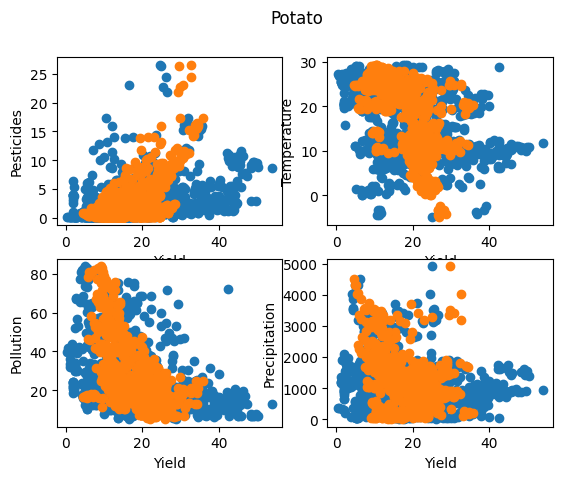

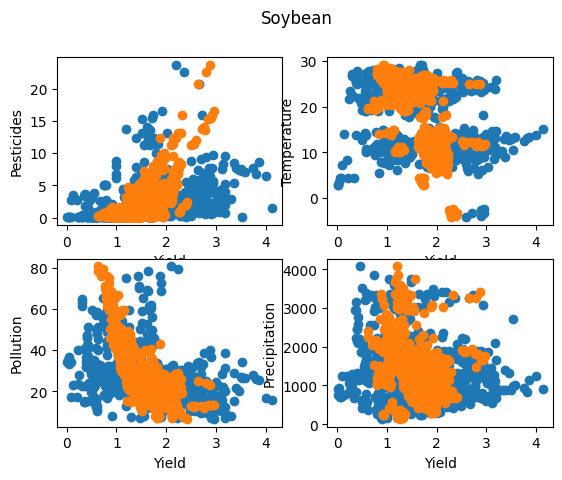

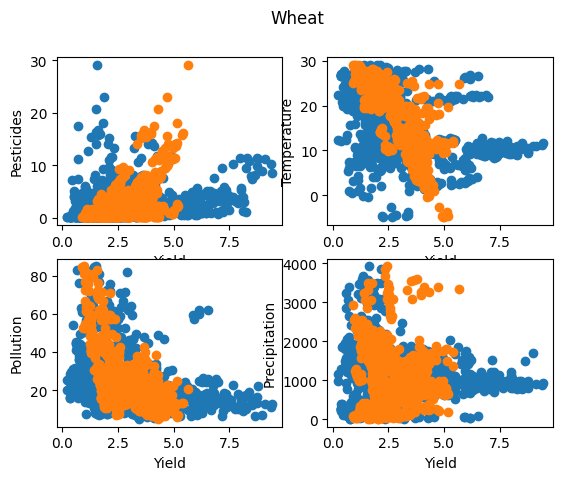

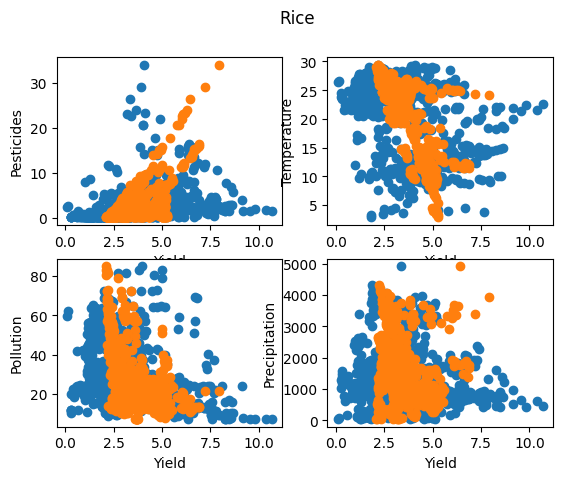

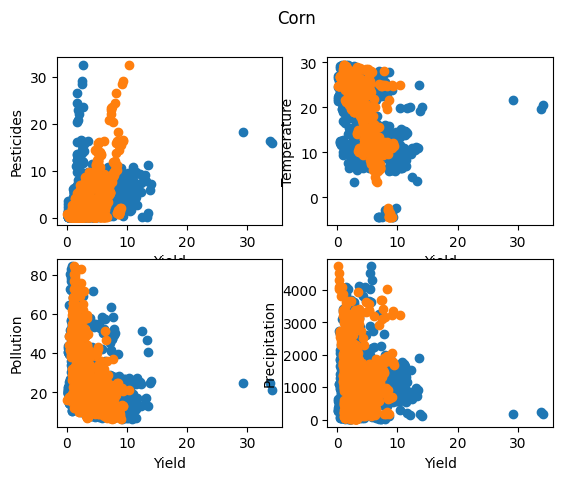

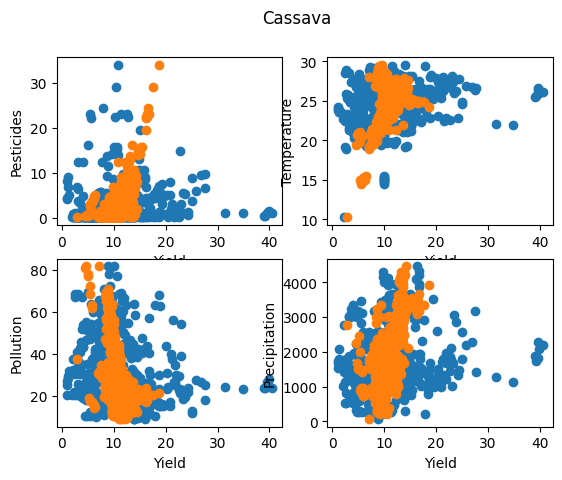

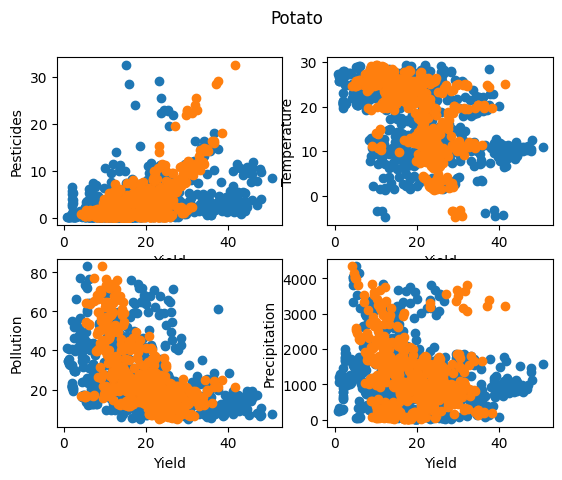

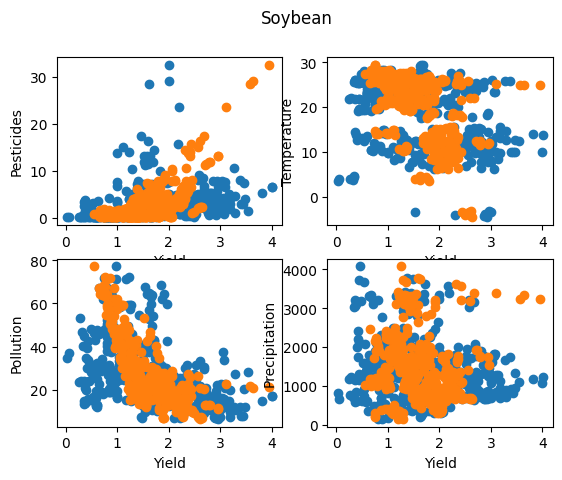

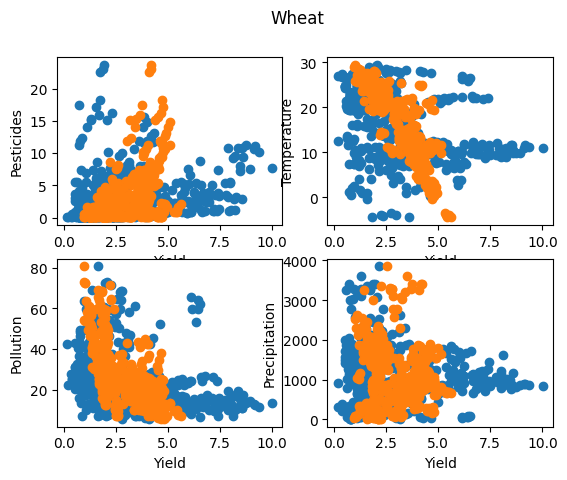

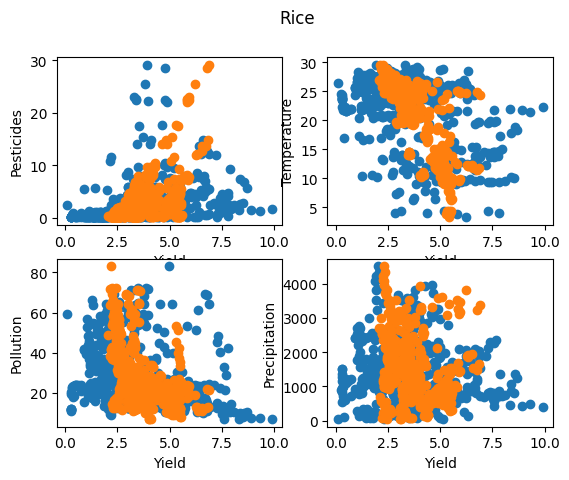

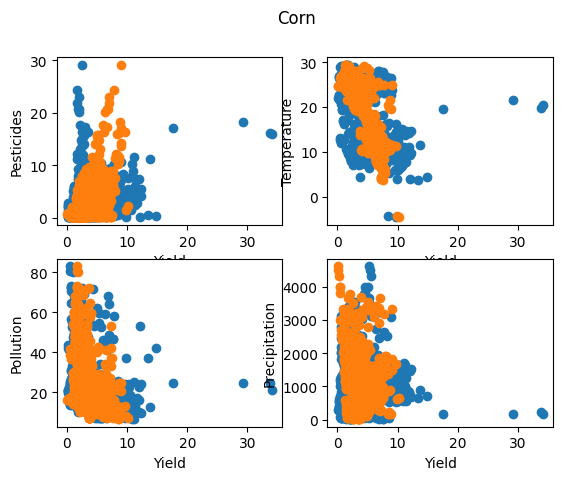

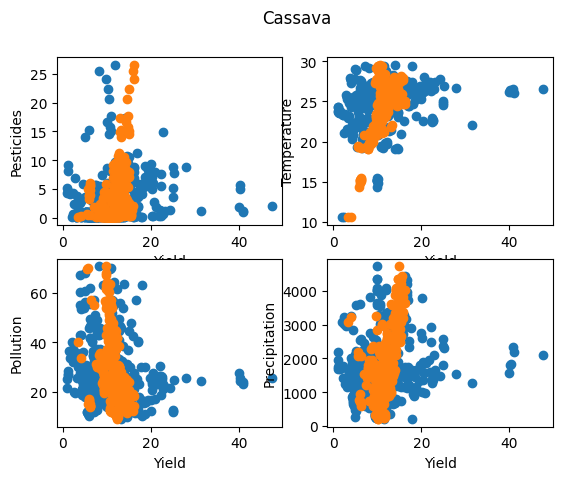

In [ ]:
features = ['Pesticides','Temperature', 'Pollution', 'Precipitation']
target = ["Yield"]

random_state = 100
test_percent = 0.3

iterations = 1500
alpha = 0.01

#store beta values for site
betas = {}

m2e = {}

for crop in Crops:

    beta, pred, features_test, target_test, J_storage, means, stds  = train_model_z(df, crop, features, target, random_state, test_percent, iterations, alpha)
    betas[crop] = beta


    m2e[crop] =  mean_squared_error(target_test,pred)

    
    display_results(pred, features_test, target_test, J_storage, features, crop)




In [42]:
#Test number of iterations with different random states to check it is not one-off

features = ['Pesticides','Temperature', 'Pollution', 'Precipitation']
target = ["Yield"]

random_states = [1,20,100]

test_percent = 0.3

list_of_iterations = [1000,1500,2000,2500]

alpha = 0.01



for iterations in list_of_iterations:
    print(f"No. Iterations: {iterations}")

    #store beta & m2e values for site
    betas = {}
    m2e = {}

    for random_state in random_states:
        m2e[random_state] = {}
        for crop in Crops:

            beta, pred, features_test, target_test, J_storage, means, stds  = train_model_z(df, crop, features, target, random_state, test_percent, iterations, alpha)
            betas[crop] = beta

            m2e[random_state][crop] =  mean_squared_error(target_test,pred)
        
    print(f"m2es: {m2e}")
    
    print("Average m2e: ")
    for crop in Crops:
        total = 0
        for random_state in random_states:
            total += m2e[random_state][crop]

    print(total/(len(Crops)*len(random_states)))

    print()
        
        #display_results(pred, features_test, target_test, J_storage, features, crop)




<cell>21: error: Need type annotation for "m2e" (hint: "m2e: dict[<type>, <type>] = ...")  [var-annotated]


No. Iterations: 1000
       Pesticides  Temperature  Pollution  Precipitation
2            0.17        12.28  22.961579      966.86530
8            0.17        11.23  22.703110     1166.13950
14           0.17        11.82  22.482896     1007.95886
20           0.17        11.78  22.297132     1104.63880
26           0.29        12.75  22.142012      940.75476
...           ...          ...        ...            ...
23702        0.53        22.25  22.570698      713.60077
23708        0.53        21.73  17.997754      975.70154
23714        0.53        22.09  19.112099      692.69950
23720        0.53        22.37  18.528607      608.31180
23726        0.53        21.93  19.494180      814.14435

[3333 rows x 4 columns]


C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
3            0.17        12.28  22.961579      966.86530
9            0.17        11.23  22.703110     1166.13950
15           0.17        11.82  22.482896     1007.95886
21           0.17        11.78  22.297132     1104.63880
27           0.29        12.75  22.142012      940.75476
...           ...          ...        ...            ...
23703        0.53        22.25  22.570698      713.60077
23709        0.53        21.73  17.997754      975.70154
23715        0.53        22.09  19.112099      692.69950
23721        0.53        22.37  18.528607      608.31180
23727        0.53        21.93  19.494180      814.14435

[2060 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
4            0.17        12.28  22.961579      966.86530
10           0.17        11.23  22.703110     1166.13950
16           0.17        11.82  22.482896     1007.95886
22           0.17        11.78  22.297132     1104.63880
28    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
5            0.17        12.28  22.961579     966.865300
11           0.17        11.23  22.703110    1166.139500
17           0.17        11.82  22.482896    1007.958860
23           0.17        11.78  22.297132    1104.638800
191          0.75        23.58  22.359370      82.725784
...           ...          ...        ...            ...
23705        0.53        22.25  22.570698     713.600770
23711        0.53        21.73  17.997754     975.701540
23717        0.53        22.09  19.112099     692.699500
23723        0.53        22.37  18.528607     608.311800
23729        0.53        21.93  19.494180     814.144350

[2598 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
6            0.17        11.23  22.703110     1166.13950
12           0.17        11.82  22.482896     1007.95886
18           0.17        11.78  22.297132     1104.63880
24           0.29        12.75  22.142012      940.75476
30    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
373          0.02        21.74  23.831767     1219.21510
379          0.03        21.56  23.443967     1130.23960
385          0.01        21.72  23.129464     1095.74330
391          0.05        21.60  22.895329     1216.95580
397          0.01        21.68  22.748636     1082.42520
...           ...          ...        ...            ...
23701        0.53        22.25  22.570698      713.60077
23707        0.53        21.73  17.997754      975.70154
23713        0.53        22.09  19.112099      692.69950
23719        0.53        22.37  18.528607      608.31180
23725        0.53        21.93  19.494180      814.14435

[1786 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
2            0.17        12.28  22.961579      966.86530
8            0.17        11.23  22.703110     1166.13950
14           0.17        11.82  22.482896     1007.95886
20           0.17        11.78  22.297132     1104.63880
26    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
3            0.17        12.28  22.961579      966.86530
9            0.17        11.23  22.703110     1166.13950
15           0.17        11.82  22.482896     1007.95886
21           0.17        11.78  22.297132     1104.63880
27           0.29        12.75  22.142012      940.75476
...           ...          ...        ...            ...
23703        0.53        22.25  22.570698      713.60077
23709        0.53        21.73  17.997754      975.70154
23715        0.53        22.09  19.112099      692.69950
23721        0.53        22.37  18.528607      608.31180
23727        0.53        21.93  19.494180      814.14435

[2060 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
4            0.17        12.28  22.961579      966.86530
10           0.17        11.23  22.703110     1166.13950
16           0.17        11.82  22.482896     1007.95886
22           0.17        11.78  22.297132     1104.63880
28    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
5            0.17        12.28  22.961579     966.865300
11           0.17        11.23  22.703110    1166.139500
17           0.17        11.82  22.482896    1007.958860
23           0.17        11.78  22.297132    1104.638800
191          0.75        23.58  22.359370      82.725784
...           ...          ...        ...            ...
23705        0.53        22.25  22.570698     713.600770
23711        0.53        21.73  17.997754     975.701540
23717        0.53        22.09  19.112099     692.699500
23723        0.53        22.37  18.528607     608.311800
23729        0.53        21.93  19.494180     814.144350

[2598 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
6            0.17        11.23  22.703110     1166.13950
12           0.17        11.82  22.482896     1007.95886
18           0.17        11.78  22.297132     1104.63880
24           0.29        12.75  22.142012      940.75476
30    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
373          0.02        21.74  23.831767     1219.21510
379          0.03        21.56  23.443967     1130.23960
385          0.01        21.72  23.129464     1095.74330
391          0.05        21.60  22.895329     1216.95580
397          0.01        21.68  22.748636     1082.42520
...           ...          ...        ...            ...
23701        0.53        22.25  22.570698      713.60077
23707        0.53        21.73  17.997754      975.70154
23713        0.53        22.09  19.112099      692.69950
23719        0.53        22.37  18.528607      608.31180
23725        0.53        21.93  19.494180      814.14435

[1786 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
2            0.17        12.28  22.961579      966.86530
8            0.17        11.23  22.703110     1166.13950
14           0.17        11.82  22.482896     1007.95886
20           0.17        11.78  22.297132     1104.63880
26    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
3            0.17        12.28  22.961579      966.86530
9            0.17        11.23  22.703110     1166.13950
15           0.17        11.82  22.482896     1007.95886
21           0.17        11.78  22.297132     1104.63880
27           0.29        12.75  22.142012      940.75476
...           ...          ...        ...            ...
23703        0.53        22.25  22.570698      713.60077
23709        0.53        21.73  17.997754      975.70154
23715        0.53        22.09  19.112099      692.69950
23721        0.53        22.37  18.528607      608.31180
23727        0.53        21.93  19.494180      814.14435

[2060 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
4            0.17        12.28  22.961579      966.86530
10           0.17        11.23  22.703110     1166.13950
16           0.17        11.82  22.482896     1007.95886
22           0.17        11.78  22.297132     1104.63880
28    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
5            0.17        12.28  22.961579     966.865300
11           0.17        11.23  22.703110    1166.139500
17           0.17        11.82  22.482896    1007.958860
23           0.17        11.78  22.297132    1104.638800
191          0.75        23.58  22.359370      82.725784
...           ...          ...        ...            ...
23705        0.53        22.25  22.570698     713.600770
23711        0.53        21.73  17.997754     975.701540
23717        0.53        22.09  19.112099     692.699500
23723        0.53        22.37  18.528607     608.311800
23729        0.53        21.93  19.494180     814.144350

[2598 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
6            0.17        11.23  22.703110     1166.13950
12           0.17        11.82  22.482896     1007.95886
18           0.17        11.78  22.297132     1104.63880
24           0.29        12.75  22.142012      940.75476
30    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
373          0.02        21.74  23.831767     1219.21510
379          0.03        21.56  23.443967     1130.23960
385          0.01        21.72  23.129464     1095.74330
391          0.05        21.60  22.895329     1216.95580
397          0.01        21.68  22.748636     1082.42520
...           ...          ...        ...            ...
23701        0.53        22.25  22.570698      713.60077
23707        0.53        21.73  17.997754      975.70154
23713        0.53        22.09  19.112099      692.69950
23719        0.53        22.37  18.528607      608.31180
23725        0.53        21.93  19.494180      814.14435

[1786 rows x 4 columns]
m2es: {1: {'Potato': Yield    76.228907
dtype: float64, 'Soybean': Yield    0.47357
dtype: float64, 'Wheat': Yield    2.641253
dtype: float64, 'Rice': Yield    2.697388
dtype: float64, 'Corn': Yield    6.413886
dtype: float64, 'Cassava': Yield    37.947601
dtype: float64}, 20: {'Potato': Yi

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
3            0.17        12.28  22.961579      966.86530
9            0.17        11.23  22.703110     1166.13950
15           0.17        11.82  22.482896     1007.95886
21           0.17        11.78  22.297132     1104.63880
27           0.29        12.75  22.142012      940.75476
...           ...          ...        ...            ...
23703        0.53        22.25  22.570698      713.60077
23709        0.53        21.73  17.997754      975.70154
23715        0.53        22.09  19.112099      692.69950
23721        0.53        22.37  18.528607      608.31180
23727        0.53        21.93  19.494180      814.14435

[2060 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
4            0.17        12.28  22.961579      966.86530
10           0.17        11.23  22.703110     1166.13950
16           0.17        11.82  22.482896     1007.95886
22           0.17        11.78  22.297132     1104.63880
28    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
5            0.17        12.28  22.961579     966.865300
11           0.17        11.23  22.703110    1166.139500
17           0.17        11.82  22.482896    1007.958860
23           0.17        11.78  22.297132    1104.638800
191          0.75        23.58  22.359370      82.725784
...           ...          ...        ...            ...
23705        0.53        22.25  22.570698     713.600770
23711        0.53        21.73  17.997754     975.701540
23717        0.53        22.09  19.112099     692.699500
23723        0.53        22.37  18.528607     608.311800
23729        0.53        21.93  19.494180     814.144350

[2598 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
6            0.17        11.23  22.703110     1166.13950
12           0.17        11.82  22.482896     1007.95886
18           0.17        11.78  22.297132     1104.63880
24           0.29        12.75  22.142012      940.75476
30    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
373          0.02        21.74  23.831767     1219.21510
379          0.03        21.56  23.443967     1130.23960
385          0.01        21.72  23.129464     1095.74330
391          0.05        21.60  22.895329     1216.95580
397          0.01        21.68  22.748636     1082.42520
...           ...          ...        ...            ...
23701        0.53        22.25  22.570698      713.60077
23707        0.53        21.73  17.997754      975.70154
23713        0.53        22.09  19.112099      692.69950
23719        0.53        22.37  18.528607      608.31180
23725        0.53        21.93  19.494180      814.14435

[1786 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
2            0.17        12.28  22.961579      966.86530
8            0.17        11.23  22.703110     1166.13950
14           0.17        11.82  22.482896     1007.95886
20           0.17        11.78  22.297132     1104.63880
26    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
3            0.17        12.28  22.961579      966.86530
9            0.17        11.23  22.703110     1166.13950
15           0.17        11.82  22.482896     1007.95886
21           0.17        11.78  22.297132     1104.63880
27           0.29        12.75  22.142012      940.75476
...           ...          ...        ...            ...
23703        0.53        22.25  22.570698      713.60077
23709        0.53        21.73  17.997754      975.70154
23715        0.53        22.09  19.112099      692.69950
23721        0.53        22.37  18.528607      608.31180
23727        0.53        21.93  19.494180      814.14435

[2060 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
4            0.17        12.28  22.961579      966.86530
10           0.17        11.23  22.703110     1166.13950
16           0.17        11.82  22.482896     1007.95886
22           0.17        11.78  22.297132     1104.63880
28    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
5            0.17        12.28  22.961579     966.865300
11           0.17        11.23  22.703110    1166.139500
17           0.17        11.82  22.482896    1007.958860
23           0.17        11.78  22.297132    1104.638800
191          0.75        23.58  22.359370      82.725784
...           ...          ...        ...            ...
23705        0.53        22.25  22.570698     713.600770
23711        0.53        21.73  17.997754     975.701540
23717        0.53        22.09  19.112099     692.699500
23723        0.53        22.37  18.528607     608.311800
23729        0.53        21.93  19.494180     814.144350

[2598 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
6            0.17        11.23  22.703110     1166.13950
12           0.17        11.82  22.482896     1007.95886
18           0.17        11.78  22.297132     1104.63880
24           0.29        12.75  22.142012      940.75476
30    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
373          0.02        21.74  23.831767     1219.21510
379          0.03        21.56  23.443967     1130.23960
385          0.01        21.72  23.129464     1095.74330
391          0.05        21.60  22.895329     1216.95580
397          0.01        21.68  22.748636     1082.42520
...           ...          ...        ...            ...
23701        0.53        22.25  22.570698      713.60077
23707        0.53        21.73  17.997754      975.70154
23713        0.53        22.09  19.112099      692.69950
23719        0.53        22.37  18.528607      608.31180
23725        0.53        21.93  19.494180      814.14435

[1786 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
2            0.17        12.28  22.961579      966.86530
8            0.17        11.23  22.703110     1166.13950
14           0.17        11.82  22.482896     1007.95886
20           0.17        11.78  22.297132     1104.63880
26    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
3            0.17        12.28  22.961579      966.86530
9            0.17        11.23  22.703110     1166.13950
15           0.17        11.82  22.482896     1007.95886
21           0.17        11.78  22.297132     1104.63880
27           0.29        12.75  22.142012      940.75476
...           ...          ...        ...            ...
23703        0.53        22.25  22.570698      713.60077
23709        0.53        21.73  17.997754      975.70154
23715        0.53        22.09  19.112099      692.69950
23721        0.53        22.37  18.528607      608.31180
23727        0.53        21.93  19.494180      814.14435

[2060 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
4            0.17        12.28  22.961579      966.86530
10           0.17        11.23  22.703110     1166.13950
16           0.17        11.82  22.482896     1007.95886
22           0.17        11.78  22.297132     1104.63880
28    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
5            0.17        12.28  22.961579     966.865300
11           0.17        11.23  22.703110    1166.139500
17           0.17        11.82  22.482896    1007.958860
23           0.17        11.78  22.297132    1104.638800
191          0.75        23.58  22.359370      82.725784
...           ...          ...        ...            ...
23705        0.53        22.25  22.570698     713.600770
23711        0.53        21.73  17.997754     975.701540
23717        0.53        22.09  19.112099     692.699500
23723        0.53        22.37  18.528607     608.311800
23729        0.53        21.93  19.494180     814.144350

[2598 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
6            0.17        11.23  22.703110     1166.13950
12           0.17        11.82  22.482896     1007.95886
18           0.17        11.78  22.297132     1104.63880
24           0.29        12.75  22.142012      940.75476
30    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
373          0.02        21.74  23.831767     1219.21510
379          0.03        21.56  23.443967     1130.23960
385          0.01        21.72  23.129464     1095.74330
391          0.05        21.60  22.895329     1216.95580
397          0.01        21.68  22.748636     1082.42520
...           ...          ...        ...            ...
23701        0.53        22.25  22.570698      713.60077
23707        0.53        21.73  17.997754      975.70154
23713        0.53        22.09  19.112099      692.69950
23719        0.53        22.37  18.528607      608.31180
23725        0.53        21.93  19.494180      814.14435

[1786 rows x 4 columns]
m2es: {1: {'Potato': Yield    76.234587
dtype: float64, 'Soybean': Yield    0.473539
dtype: float64, 'Wheat': Yield    2.641107
dtype: float64, 'Rice': Yield    2.697529
dtype: float64, 'Corn': Yield    6.415236
dtype: float64, 'Cassava': Yield    37.947477
dtype: float64}, 20: {'Potato': Y

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
3            0.17        12.28  22.961579      966.86530
9            0.17        11.23  22.703110     1166.13950
15           0.17        11.82  22.482896     1007.95886
21           0.17        11.78  22.297132     1104.63880
27           0.29        12.75  22.142012      940.75476
...           ...          ...        ...            ...
23703        0.53        22.25  22.570698      713.60077
23709        0.53        21.73  17.997754      975.70154
23715        0.53        22.09  19.112099      692.69950
23721        0.53        22.37  18.528607      608.31180
23727        0.53        21.93  19.494180      814.14435

[2060 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
4            0.17        12.28  22.961579      966.86530
10           0.17        11.23  22.703110     1166.13950
16           0.17        11.82  22.482896     1007.95886
22           0.17        11.78  22.297132     1104.63880
28    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
5            0.17        12.28  22.961579     966.865300
11           0.17        11.23  22.703110    1166.139500
17           0.17        11.82  22.482896    1007.958860
23           0.17        11.78  22.297132    1104.638800
191          0.75        23.58  22.359370      82.725784
...           ...          ...        ...            ...
23705        0.53        22.25  22.570698     713.600770
23711        0.53        21.73  17.997754     975.701540
23717        0.53        22.09  19.112099     692.699500
23723        0.53        22.37  18.528607     608.311800
23729        0.53        21.93  19.494180     814.144350

[2598 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
6            0.17        11.23  22.703110     1166.13950
12           0.17        11.82  22.482896     1007.95886
18           0.17        11.78  22.297132     1104.63880
24           0.29        12.75  22.142012      940.75476
30    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
373          0.02        21.74  23.831767     1219.21510
379          0.03        21.56  23.443967     1130.23960
385          0.01        21.72  23.129464     1095.74330
391          0.05        21.60  22.895329     1216.95580
397          0.01        21.68  22.748636     1082.42520
...           ...          ...        ...            ...
23701        0.53        22.25  22.570698      713.60077
23707        0.53        21.73  17.997754      975.70154
23713        0.53        22.09  19.112099      692.69950
23719        0.53        22.37  18.528607      608.31180
23725        0.53        21.93  19.494180      814.14435

[1786 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
2            0.17        12.28  22.961579      966.86530
8            0.17        11.23  22.703110     1166.13950
14           0.17        11.82  22.482896     1007.95886
20           0.17        11.78  22.297132     1104.63880
26    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
3            0.17        12.28  22.961579      966.86530
9            0.17        11.23  22.703110     1166.13950
15           0.17        11.82  22.482896     1007.95886
21           0.17        11.78  22.297132     1104.63880
27           0.29        12.75  22.142012      940.75476
...           ...          ...        ...            ...
23703        0.53        22.25  22.570698      713.60077
23709        0.53        21.73  17.997754      975.70154
23715        0.53        22.09  19.112099      692.69950
23721        0.53        22.37  18.528607      608.31180
23727        0.53        21.93  19.494180      814.14435

[2060 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
4            0.17        12.28  22.961579      966.86530
10           0.17        11.23  22.703110     1166.13950
16           0.17        11.82  22.482896     1007.95886
22           0.17        11.78  22.297132     1104.63880
28    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
5            0.17        12.28  22.961579     966.865300
11           0.17        11.23  22.703110    1166.139500
17           0.17        11.82  22.482896    1007.958860
23           0.17        11.78  22.297132    1104.638800
191          0.75        23.58  22.359370      82.725784
...           ...          ...        ...            ...
23705        0.53        22.25  22.570698     713.600770
23711        0.53        21.73  17.997754     975.701540
23717        0.53        22.09  19.112099     692.699500
23723        0.53        22.37  18.528607     608.311800
23729        0.53        21.93  19.494180     814.144350

[2598 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
6            0.17        11.23  22.703110     1166.13950
12           0.17        11.82  22.482896     1007.95886
18           0.17        11.78  22.297132     1104.63880
24           0.29        12.75  22.142012      940.75476
30    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
373          0.02        21.74  23.831767     1219.21510
379          0.03        21.56  23.443967     1130.23960
385          0.01        21.72  23.129464     1095.74330
391          0.05        21.60  22.895329     1216.95580
397          0.01        21.68  22.748636     1082.42520
...           ...          ...        ...            ...
23701        0.53        22.25  22.570698      713.60077
23707        0.53        21.73  17.997754      975.70154
23713        0.53        22.09  19.112099      692.69950
23719        0.53        22.37  18.528607      608.31180
23725        0.53        21.93  19.494180      814.14435

[1786 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
2            0.17        12.28  22.961579      966.86530
8            0.17        11.23  22.703110     1166.13950
14           0.17        11.82  22.482896     1007.95886
20           0.17        11.78  22.297132     1104.63880
26    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
3            0.17        12.28  22.961579      966.86530
9            0.17        11.23  22.703110     1166.13950
15           0.17        11.82  22.482896     1007.95886
21           0.17        11.78  22.297132     1104.63880
27           0.29        12.75  22.142012      940.75476
...           ...          ...        ...            ...
23703        0.53        22.25  22.570698      713.60077
23709        0.53        21.73  17.997754      975.70154
23715        0.53        22.09  19.112099      692.69950
23721        0.53        22.37  18.528607      608.31180
23727        0.53        21.93  19.494180      814.14435

[2060 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
4            0.17        12.28  22.961579      966.86530
10           0.17        11.23  22.703110     1166.13950
16           0.17        11.82  22.482896     1007.95886
22           0.17        11.78  22.297132     1104.63880
28    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
5            0.17        12.28  22.961579     966.865300
11           0.17        11.23  22.703110    1166.139500
17           0.17        11.82  22.482896    1007.958860
23           0.17        11.78  22.297132    1104.638800
191          0.75        23.58  22.359370      82.725784
...           ...          ...        ...            ...
23705        0.53        22.25  22.570698     713.600770
23711        0.53        21.73  17.997754     975.701540
23717        0.53        22.09  19.112099     692.699500
23723        0.53        22.37  18.528607     608.311800
23729        0.53        21.93  19.494180     814.144350

[2598 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
6            0.17        11.23  22.703110     1166.13950
12           0.17        11.82  22.482896     1007.95886
18           0.17        11.78  22.297132     1104.63880
24           0.29        12.75  22.142012      940.75476
30    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
373          0.02        21.74  23.831767     1219.21510
379          0.03        21.56  23.443967     1130.23960
385          0.01        21.72  23.129464     1095.74330
391          0.05        21.60  22.895329     1216.95580
397          0.01        21.68  22.748636     1082.42520
...           ...          ...        ...            ...
23701        0.53        22.25  22.570698      713.60077
23707        0.53        21.73  17.997754      975.70154
23713        0.53        22.09  19.112099      692.69950
23719        0.53        22.37  18.528607      608.31180
23725        0.53        21.93  19.494180      814.14435

[1786 rows x 4 columns]
m2es: {1: {'Potato': Yield    76.23515
dtype: float64, 'Soybean': Yield    0.473537
dtype: float64, 'Wheat': Yield    2.64109
dtype: float64, 'Rice': Yield    2.697536
dtype: float64, 'Corn': Yield    6.415343
dtype: float64, 'Cassava': Yield    37.947475
dtype: float64}, 20: {'Potato': Yie

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
3            0.17        12.28  22.961579      966.86530
9            0.17        11.23  22.703110     1166.13950
15           0.17        11.82  22.482896     1007.95886
21           0.17        11.78  22.297132     1104.63880
27           0.29        12.75  22.142012      940.75476
...           ...          ...        ...            ...
23703        0.53        22.25  22.570698      713.60077
23709        0.53        21.73  17.997754      975.70154
23715        0.53        22.09  19.112099      692.69950
23721        0.53        22.37  18.528607      608.31180
23727        0.53        21.93  19.494180      814.14435

[2060 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
4            0.17        12.28  22.961579      966.86530
10           0.17        11.23  22.703110     1166.13950
16           0.17        11.82  22.482896     1007.95886
22           0.17        11.78  22.297132     1104.63880
28    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
5            0.17        12.28  22.961579     966.865300
11           0.17        11.23  22.703110    1166.139500
17           0.17        11.82  22.482896    1007.958860
23           0.17        11.78  22.297132    1104.638800
191          0.75        23.58  22.359370      82.725784
...           ...          ...        ...            ...
23705        0.53        22.25  22.570698     713.600770
23711        0.53        21.73  17.997754     975.701540
23717        0.53        22.09  19.112099     692.699500
23723        0.53        22.37  18.528607     608.311800
23729        0.53        21.93  19.494180     814.144350

[2598 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
6            0.17        11.23  22.703110     1166.13950
12           0.17        11.82  22.482896     1007.95886
18           0.17        11.78  22.297132     1104.63880
24           0.29        12.75  22.142012      940.75476
30    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
373          0.02        21.74  23.831767     1219.21510
379          0.03        21.56  23.443967     1130.23960
385          0.01        21.72  23.129464     1095.74330
391          0.05        21.60  22.895329     1216.95580
397          0.01        21.68  22.748636     1082.42520
...           ...          ...        ...            ...
23701        0.53        22.25  22.570698      713.60077
23707        0.53        21.73  17.997754      975.70154
23713        0.53        22.09  19.112099      692.69950
23719        0.53        22.37  18.528607      608.31180
23725        0.53        21.93  19.494180      814.14435

[1786 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
2            0.17        12.28  22.961579      966.86530
8            0.17        11.23  22.703110     1166.13950
14           0.17        11.82  22.482896     1007.95886
20           0.17        11.78  22.297132     1104.63880
26    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
3            0.17        12.28  22.961579      966.86530
9            0.17        11.23  22.703110     1166.13950
15           0.17        11.82  22.482896     1007.95886
21           0.17        11.78  22.297132     1104.63880
27           0.29        12.75  22.142012      940.75476
...           ...          ...        ...            ...
23703        0.53        22.25  22.570698      713.60077
23709        0.53        21.73  17.997754      975.70154
23715        0.53        22.09  19.112099      692.69950
23721        0.53        22.37  18.528607      608.31180
23727        0.53        21.93  19.494180      814.14435

[2060 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
4            0.17        12.28  22.961579      966.86530
10           0.17        11.23  22.703110     1166.13950
16           0.17        11.82  22.482896     1007.95886
22           0.17        11.78  22.297132     1104.63880
28    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
5            0.17        12.28  22.961579     966.865300
11           0.17        11.23  22.703110    1166.139500
17           0.17        11.82  22.482896    1007.958860
23           0.17        11.78  22.297132    1104.638800
191          0.75        23.58  22.359370      82.725784
...           ...          ...        ...            ...
23705        0.53        22.25  22.570698     713.600770
23711        0.53        21.73  17.997754     975.701540
23717        0.53        22.09  19.112099     692.699500
23723        0.53        22.37  18.528607     608.311800
23729        0.53        21.93  19.494180     814.144350

[2598 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
6            0.17        11.23  22.703110     1166.13950
12           0.17        11.82  22.482896     1007.95886
18           0.17        11.78  22.297132     1104.63880
24           0.29        12.75  22.142012      940.75476
30    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
373          0.02        21.74  23.831767     1219.21510
379          0.03        21.56  23.443967     1130.23960
385          0.01        21.72  23.129464     1095.74330
391          0.05        21.60  22.895329     1216.95580
397          0.01        21.68  22.748636     1082.42520
...           ...          ...        ...            ...
23701        0.53        22.25  22.570698      713.60077
23707        0.53        21.73  17.997754      975.70154
23713        0.53        22.09  19.112099      692.69950
23719        0.53        22.37  18.528607      608.31180
23725        0.53        21.93  19.494180      814.14435

[1786 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
2            0.17        12.28  22.961579      966.86530
8            0.17        11.23  22.703110     1166.13950
14           0.17        11.82  22.482896     1007.95886
20           0.17        11.78  22.297132     1104.63880
26    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
3            0.17        12.28  22.961579      966.86530
9            0.17        11.23  22.703110     1166.13950
15           0.17        11.82  22.482896     1007.95886
21           0.17        11.78  22.297132     1104.63880
27           0.29        12.75  22.142012      940.75476
...           ...          ...        ...            ...
23703        0.53        22.25  22.570698      713.60077
23709        0.53        21.73  17.997754      975.70154
23715        0.53        22.09  19.112099      692.69950
23721        0.53        22.37  18.528607      608.31180
23727        0.53        21.93  19.494180      814.14435

[2060 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
4            0.17        12.28  22.961579      966.86530
10           0.17        11.23  22.703110     1166.13950
16           0.17        11.82  22.482896     1007.95886
22           0.17        11.78  22.297132     1104.63880
28    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


       Pesticides  Temperature  Pollution  Precipitation
5            0.17        12.28  22.961579     966.865300
11           0.17        11.23  22.703110    1166.139500
17           0.17        11.82  22.482896    1007.958860
23           0.17        11.78  22.297132    1104.638800
191          0.75        23.58  22.359370      82.725784
...           ...          ...        ...            ...
23705        0.53        22.25  22.570698     713.600770
23711        0.53        21.73  17.997754     975.701540
23717        0.53        22.09  19.112099     692.699500
23723        0.53        22.37  18.528607     608.311800
23729        0.53        21.93  19.494180     814.144350

[2598 rows x 4 columns]
       Pesticides  Temperature  Pollution  Precipitation
6            0.17        11.23  22.703110     1166.13950
12           0.17        11.82  22.482896     1007.95886
18           0.17        11.78  22.297132     1104.63880
24           0.29        12.75  22.142012      940.75476
30    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


[ 0.01      -5.23       4.8951809  7.593719 ]
[  34.06         29.55         85.10010987 4723.268     ]
[ 1.00000000e-02 -5.23000000e+00  6.22680169e+00  1.33100250e+02]
[  32.63         29.45         82.79136906 4267.0137    ]


C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


[ 1.00000000e-02 -5.23000000e+00  5.12673961e+00  1.15950320e+01]
[  32.63         29.48         85.10010987 4267.0137    ]
[1.00000000e-02 2.80000000e+00 6.98983894e+00 4.06000860e+01]
[  32.63         29.55         85.10010987 4723.268     ]


C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


[ 0.01       -5.23        5.63670791  7.593719  ]
[  34.06         29.55         85.10010987 4909.4116    ]
[1.00000000e-02 1.02700000e+01 8.73603502e+00 1.01568280e+02]
[  32.63         29.45         82.79136906 4909.4116    ]


C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


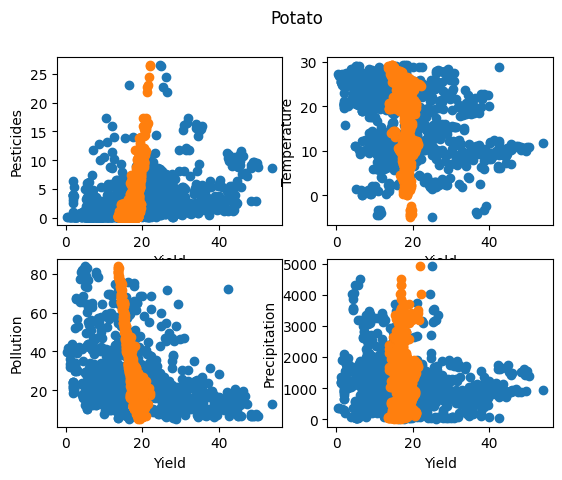

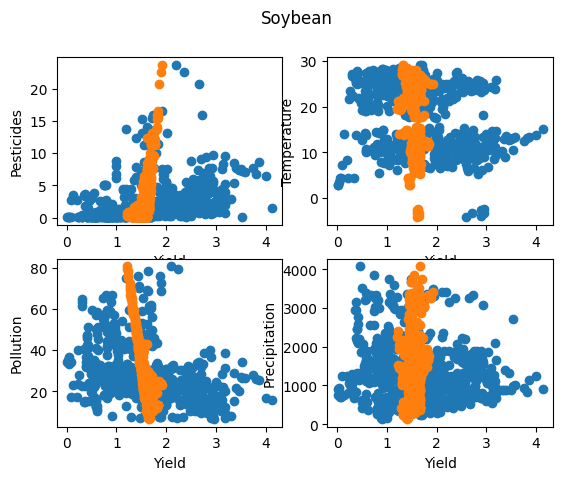

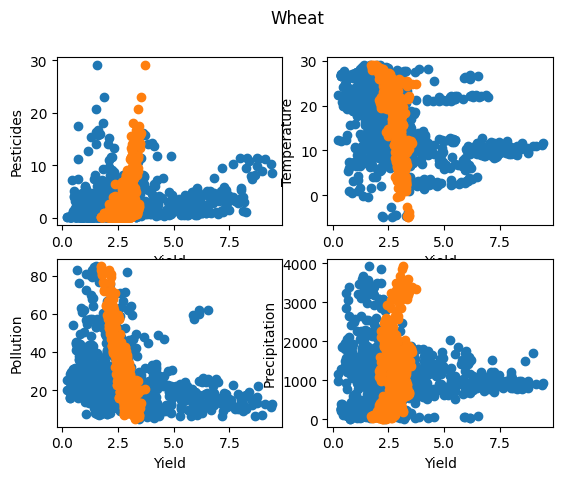

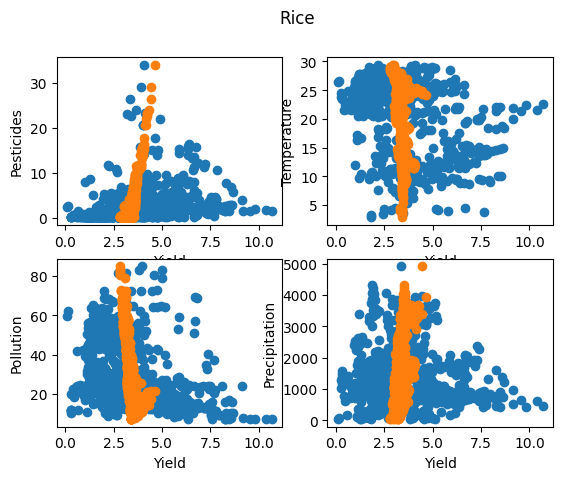

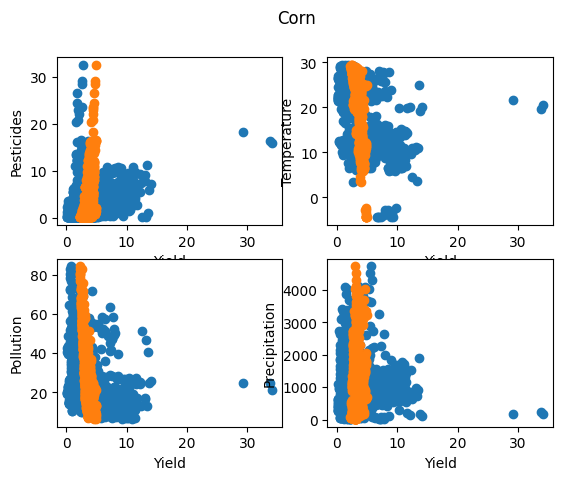

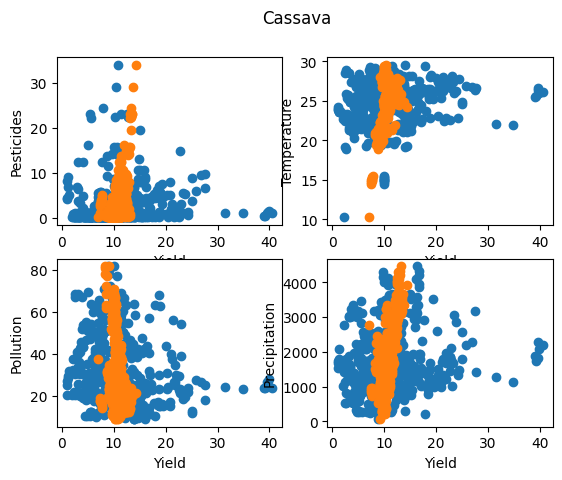

In [45]:
features = ['Pesticides','Temperature', 'Pollution', 'Precipitation']
target = ["Yield"]



random_state = 100
test_percent = 0.3

iterations = 1500
alpha = 0.01

#store beta values for site
betas2 = {}

m2e2 = {}

for crop in Crops:

    beta, pred, features_test, target_test, J_storage, mins, maxs  = train_model_minmax(df, crop, features, target, random_state, test_percent, iterations, alpha)
    betas2[crop] = beta

    print(mins)
    print(maxs)

    m2e2[crop] =  mean_squared_error(target_test,pred)
    
    display_results(pred, features_test, target_test, J_storage, features, crop)

In [46]:
print(m2e2)

{'Potato': Yield    105.924669
dtype: float64, 'Soybean': Yield    0.63264
dtype: float64, 'Wheat': Yield    3.276606
dtype: float64, 'Rice': Yield    3.290942
dtype: float64, 'Corn': Yield    10.083035
dtype: float64, 'Cassava': Yield    34.858709
dtype: float64}


C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packag

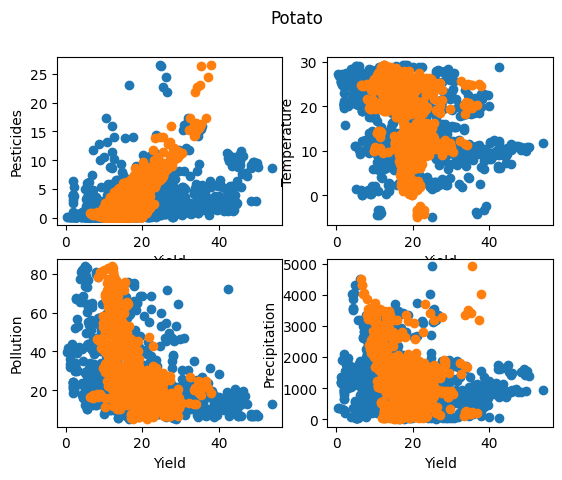

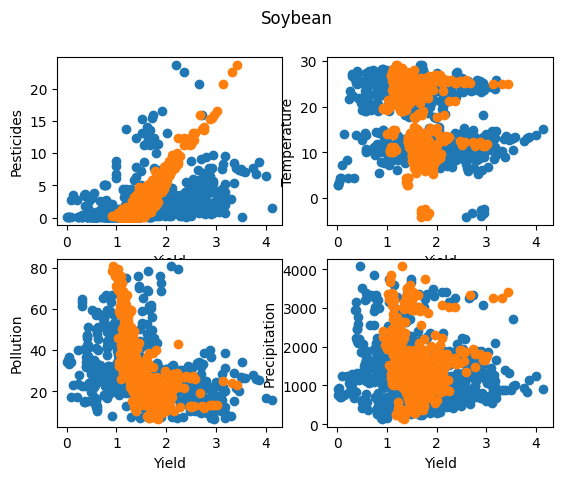

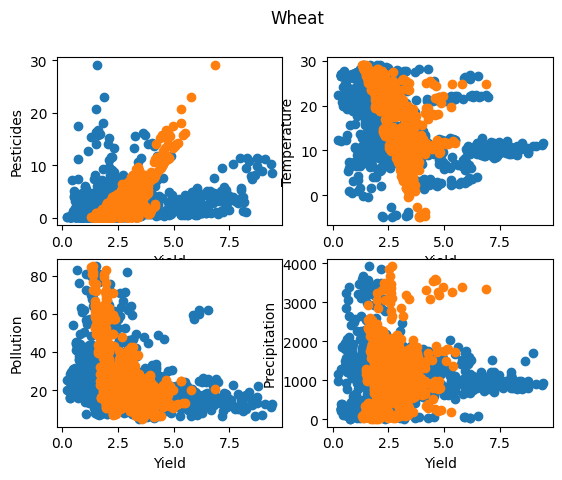

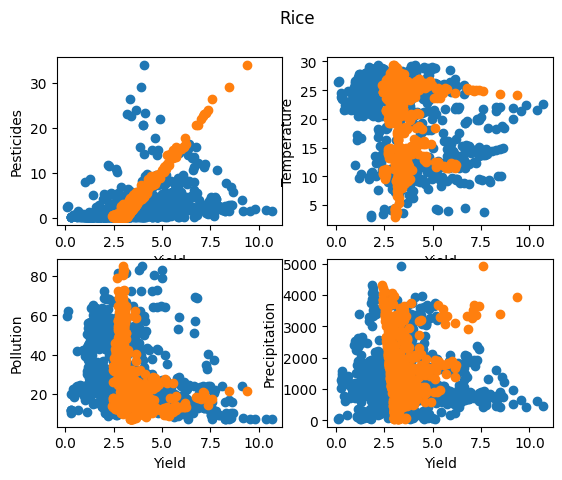

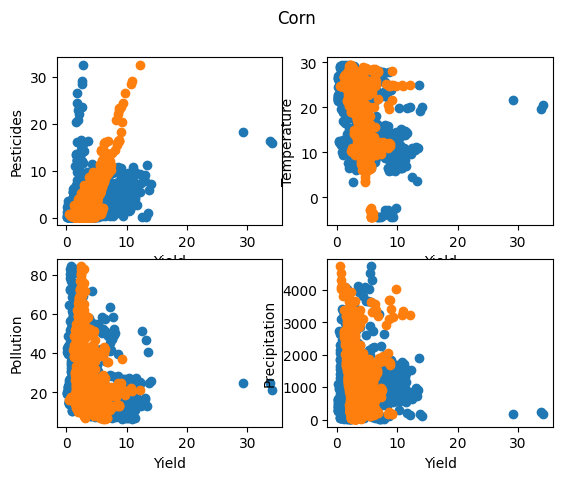

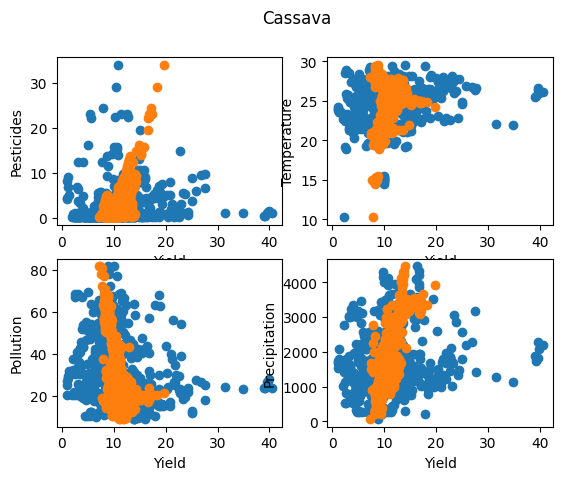

In [ ]:
features = ['Pesticides','Temperature', 'Pollution', 'Precipitation']
target = ["Yield"]



random_state = 100
test_percent = 0.3

iterations = 1500
alpha = 0.01

#store beta values for site
betas3 = {}

m2e3 = {}

for crop in Crops:

    beta, pred, features_test, target_test, J_storage, means  = train_model_scaled(df, crop, features, target, random_state, test_percent, iterations, alpha)
    betas3[crop] = beta

    m2e3[crop] =  mean_squared_error(target_test,pred)

    display_results(pred, features_test, target_test, J_storage, features, crop)

In [ ]:
print(m2e2)

In [27]:
# import math

# features = ['Pesticides', 'Pollution', 'Precipitation']
# target = ["Yield"]

# df_copy = df.copy(deep = True)
# df_copy = df_copy.loc[:,['Crop','Pesticides', 'Pollution', 'Precipitation','Yield']]
# df_copy["Precipitation"] = df_copy["Precipitation"].apply(lambda data: math.log(data))
# df_copy["Pollution"] = df_copy["Pollution"].apply(lambda data: math.log(data))
# df_copy["Pesticides"] = df_copy["Pesticides"].apply(lambda data: math.log(data))


# print(df_copy.describe())

# random_state = 100
# test_percent = 0.3

# iterations = 1500
# alpha = 0.01

# #store beta values for site
# betass = {}

# m2es = {}

# for crop in Crops:

#     beta, pred, features_test, target_test, J_storage  = train_model(df_copy, crop, features, target, random_state, test_percent, iterations, alpha)
#     betass[crop] = beta
#     m2es[crop] = mean_squared_error(target_test, pred)
    
#     display_results(pred, features_test, target_test, J_storage, features, crop)

          Crop  Temperature  Pollution  Precipitation   Yield
0         Corn        12.28  22.961579      966.86530  3.6613
2       Potato        12.28  22.961579      966.86530  6.6667
3      Soybean        12.28  22.961579      966.86530  0.7000
4        Wheat        12.28  22.961579      966.86530  3.0197
5         Rice        12.28  22.961579      966.86530  2.3333
...        ...          ...        ...            ...     ...
23725  Cassava        21.93  19.494180      814.14435  4.8301
23726   Potato        21.93  19.494180      814.14435  6.4695
23727  Soybean        21.93  19.494180      814.14435  1.8147
23728    Wheat        21.93  19.494180      814.14435  4.7796
23729     Rice        21.93  19.494180      814.14435  0.6114

[16345 rows x 5 columns]
       Temperature  Pollution  Precipitation
2            12.28  22.961579      966.86530
8            11.23  22.703110     1166.13950
14           11.82  22.482896     1007.95886
20           11.78  22.297132     1104.63880
26   

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packag

[  21.6941951    29.87501091 1415.57159389]
[  6.01578501  16.98915435 921.42230126]
       Temperature  Pollution  Precipitation
0            12.28  22.961579      966.86530
6            11.23  22.703110     1166.13950
12           11.82  22.482896     1007.95886
18           11.78  22.297132     1104.63880
24           12.75  22.142012      940.75476
...            ...        ...            ...
23700        22.25  22.570698      713.60077
23706        21.73  17.997754      975.70154
23712        22.09  19.112099      692.69950
23718        22.37  18.528607      608.31180
23724        21.93  19.494180      814.14435

[3446 rows x 3 columns]


C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


[  19.86411935   28.22579215 1248.44069347]
[  7.20303095  15.9625724  850.5741816 ]
       Temperature  Pollution  Precipitation
373          21.74  23.831767     1219.21510
379          21.56  23.443967     1130.23960
385          21.72  23.129464     1095.74330
391          21.60  22.895329     1216.95580
397          21.68  22.748636     1082.42520
...            ...        ...            ...
23701        22.25  22.570698      713.60077
23707        21.73  17.997754      975.70154
23713        22.09  19.112099      692.69950
23719        22.37  18.528607      608.31180
23725        21.93  19.494180      814.14435

[1868 rows x 3 columns]
[  24.72580275   30.33773308 1674.61118119]
[  2.80531323  16.56939942 916.51626816]


C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


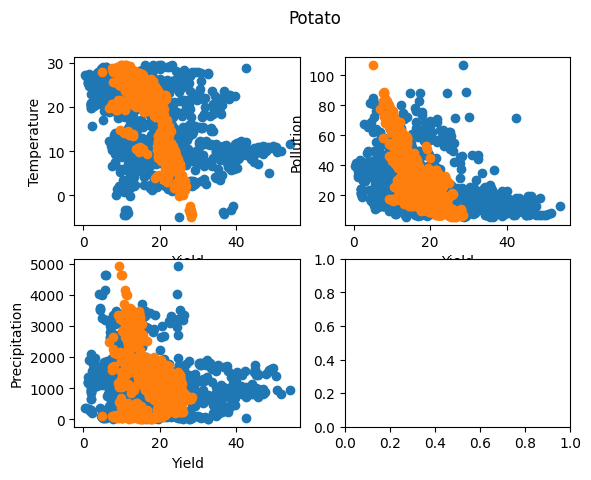

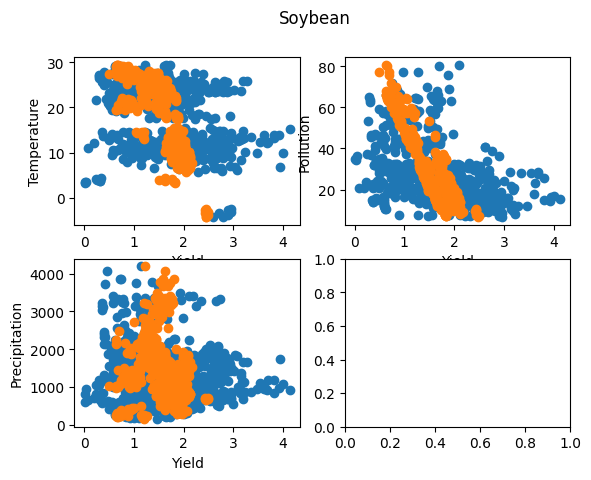

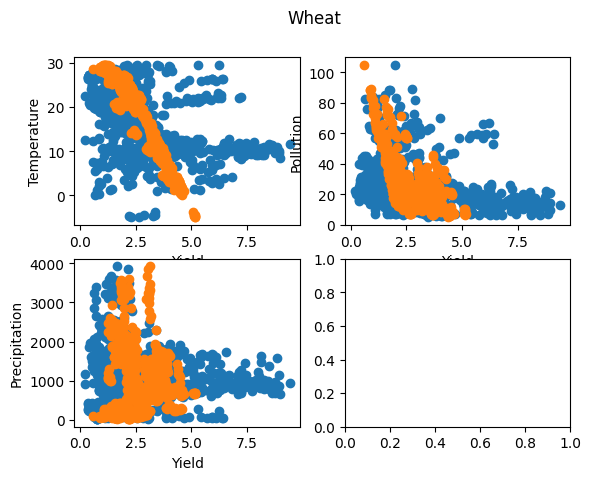

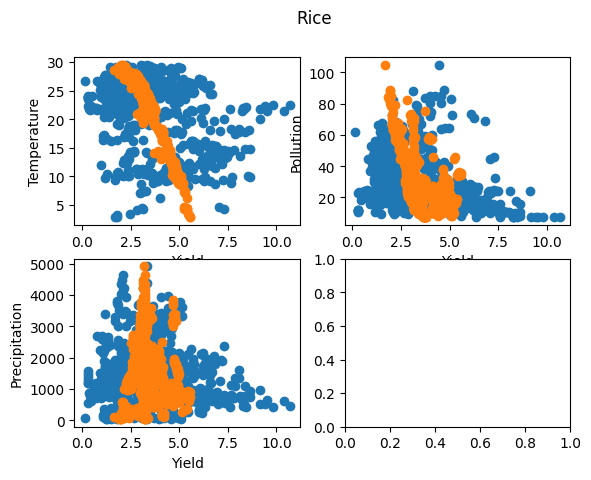

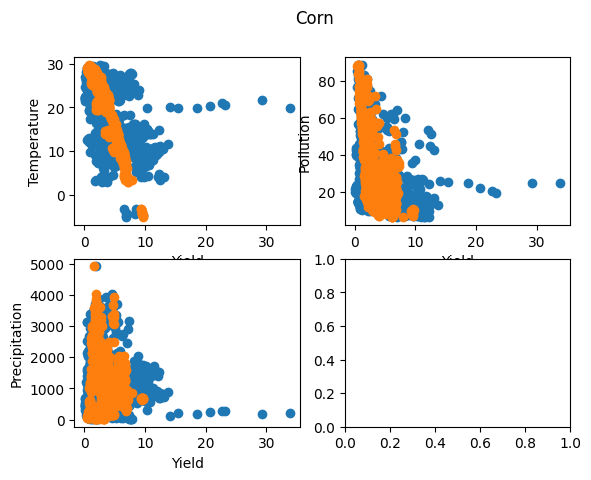

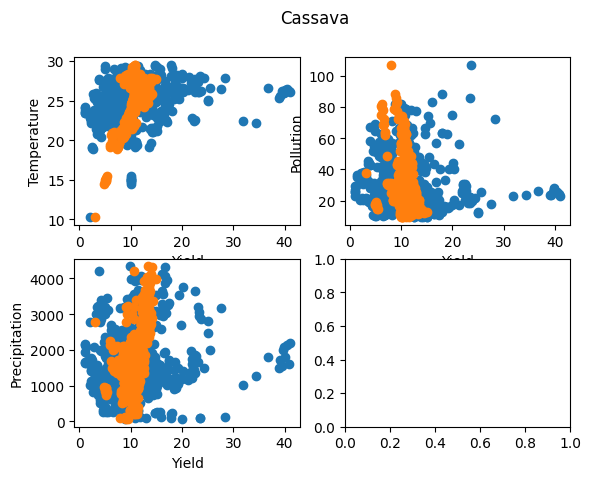

In [28]:
###Without Pesticides###

from math import sqrt
def display_results(pred, features_test, target_test, J_storage, features, crop):
    #plt.title(crop)

    #plt.plot(J_storage)

    fig,ax = plt.subplots(2,2)
    
    
    feature = 0
    for row in ax:
        for col in row:
            if feature < len(features):
                plt.suptitle(crop)
                col.set_xlabel("Yield")
                col.set_ylabel(features[feature])
                col.scatter(target_test, features_test[features[feature]])
                col.scatter(pred, features_test[features[feature]])
            feature += 1
    
features = ['Temperature', 'Pollution', 'Precipitation']
target = ["Yield"]

random_state = 100
test_percent = 0.3

iterations = 1500
alpha = 0.01

#store beta values for site
betas7 = {}

m2e7 = {}

# Read the CSV file
df2: pd.DataFrame = pd.read_csv("CheckData.csv")

#remove pesticides table
#remove rows with missing/0 values
df2 = df2.loc[:, ['Crop','Temperature', 'Pollution', 'Precipitation', 'Yield']]
df2 = df2.replace(0, np.nan)
df2 = df2.dropna()

print(df2)


for crop in Crops:

    beta, pred, features_test, target_test, J_storage, means, stds  = train_model_z(df2, crop, features, target, random_state, test_percent, iterations, alpha)
    betas7[crop] = beta

    print(means)
    print(stds)

    m2e7[crop] =  mean_squared_error(target_test,pred)

    
    display_results(pred, features_test, target_test, J_storage, features, crop)

          Crop  Temperature  Pesticides  Precipitation   Yield
0         Corn        12.28        0.17      966.86530  3.6613
2       Potato        12.28        0.17      966.86530  6.6667
3      Soybean        12.28        0.17      966.86530  0.7000
4        Wheat        12.28        0.17      966.86530  3.0197
5         Rice        12.28        0.17      966.86530  2.3333
...        ...          ...         ...            ...     ...
23725  Cassava        21.93        0.53      814.14435  4.8301
23726   Potato        21.93        0.53      814.14435  6.4695
23727  Soybean        21.93        0.53      814.14435  1.8147
23728    Wheat        21.93        0.53      814.14435  4.7796
23729     Rice        21.93        0.53      814.14435  0.6114

[15886 rows x 5 columns]
       Temperature  Pesticides  Precipitation
2            12.28        0.17      966.86530
8            11.23        0.17     1166.13950
14           11.82        0.17     1007.95886
20           11.78        0.17    

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packag

[  21.83506322    2.35233645 1448.46297813]
[  5.78199134   3.72668584 916.28619886]
       Temperature  Pesticides  Precipitation
0            12.28        0.17      966.86530
6            11.23        0.17     1166.13950
12           11.82        0.17     1007.95886
18           11.78        0.17     1104.63880
24           12.75        0.29      940.75476
...            ...         ...            ...
23700        22.25        0.53      713.60077
23706        21.73        0.53      975.70154
23712        22.09        0.53      692.69950
23718        22.37        0.53      608.31180
23724        21.93        0.53      814.14435

[3360 rows x 3 columns]


C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


[  19.68049745    2.65572704 1275.98814975]
[  7.24534649   3.76822452 845.43046023]
       Temperature  Pesticides  Precipitation
373          21.74        0.02     1219.21510
379          21.56        0.03     1130.23960
385          21.72        0.01     1095.74330
391          21.60        0.05     1216.95580
397          21.68        0.01     1082.42520
...            ...         ...            ...
23701        22.25        0.53      713.60077
23707        21.73        0.53      975.70154
23713        22.09        0.53      692.69950
23719        22.37        0.53      608.31180
23725        21.93        0.53      814.14435

[1786 rows x 3 columns]
[  24.658753      2.41206235 1744.86726533]
[  2.7686855    4.00577583 904.74069602]


C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


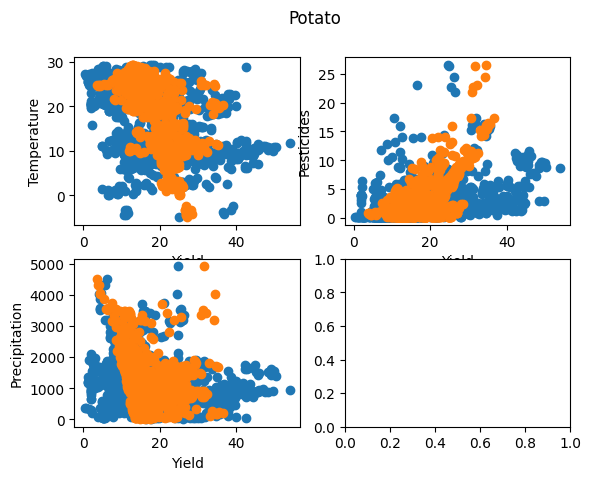

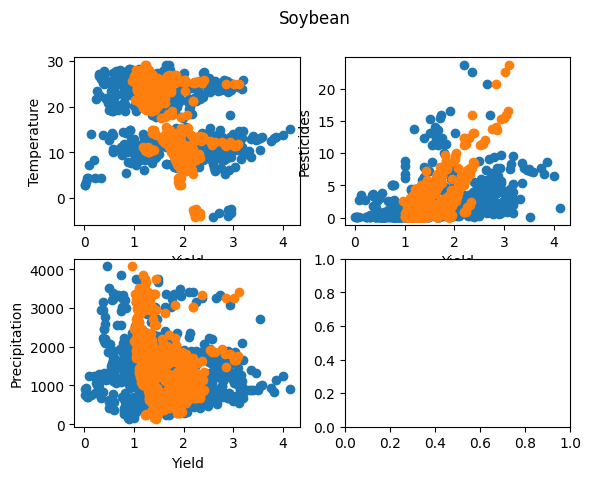

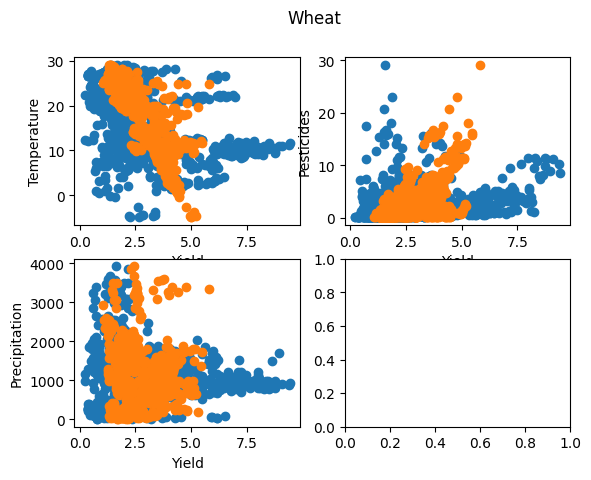

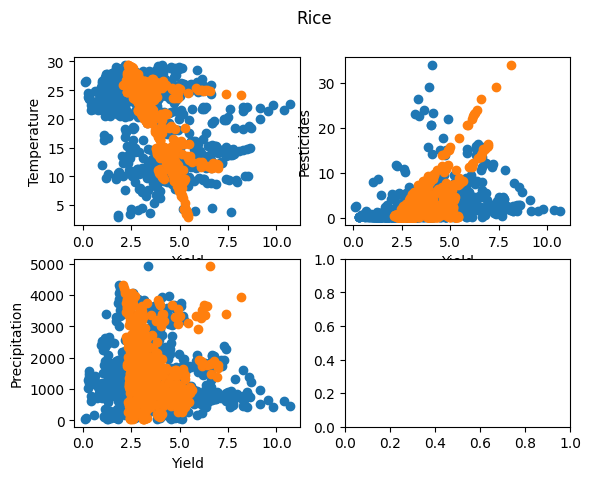

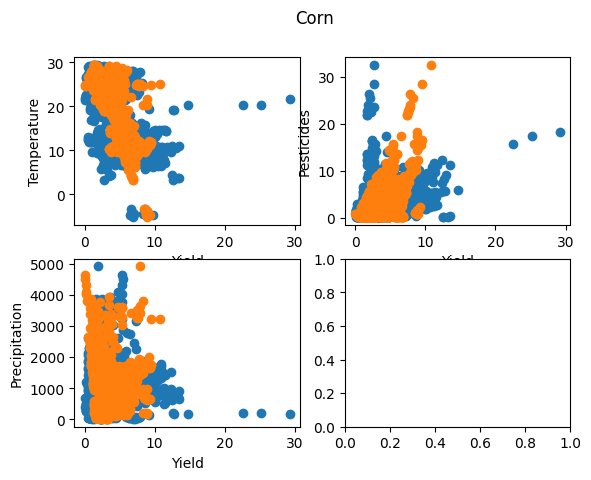

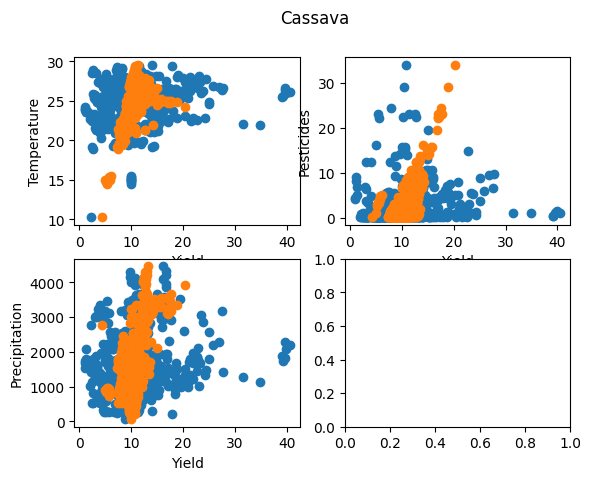

In [29]:
###Without Pollution###

from math import sqrt
def display_results(pred, features_test, target_test, J_storage, features, crop):
    #plt.title(crop)

    #plt.plot(J_storage)

    fig,ax = plt.subplots(2,2)
    
    
    feature = 0
    for row in ax:
        for col in row:
            if feature < len(features):
                plt.suptitle(crop)
                col.set_xlabel("Yield")
                col.set_ylabel(features[feature])
                col.scatter(target_test, features_test[features[feature]])
                col.scatter(pred, features_test[features[feature]])
            feature += 1
    
features = ['Temperature', 'Pesticides', 'Precipitation']
target = ["Yield"]

random_state = 100
test_percent = 0.3

iterations = 1500
alpha = 0.01

#store beta values for site
betas6 = {}

m2e6 = {}

# Read the CSV file
df2: pd.DataFrame = pd.read_csv("CheckData.csv")

#remove pollution table
#remove rows with missing/0 values
df2 = df2.loc[:, ['Crop','Temperature', 'Pesticides', 'Precipitation', 'Yield']]
df2 = df2.replace(0, np.nan)
df2 = df2.dropna()

print(df2)


for crop in Crops:

    beta, pred, features_test, target_test, J_storage, means, stds  = train_model_z(df2, crop, features, target, random_state, test_percent, iterations, alpha)
    betas6[crop] = beta

    print(means)
    print(stds)
    m2e6[crop] =  mean_squared_error(target_test,pred)

    
    display_results(pred, features_test, target_test, J_storage, features, crop)

          Crop  Pollution  Pesticides  Precipitation   Yield
0         Corn  22.961579        0.17      966.86530  3.6613
2       Potato  22.961579        0.17      966.86530  6.6667
3      Soybean  22.961579        0.17      966.86530  0.7000
4        Wheat  22.961579        0.17      966.86530  3.0197
5         Rice  22.961579        0.17      966.86530  2.3333
...        ...        ...         ...            ...     ...
23725  Cassava  19.494180        0.53      814.14435  4.8301
23726   Potato  19.494180        0.53      814.14435  6.4695
23727  Soybean  19.494180        0.53      814.14435  1.8147
23728    Wheat  19.494180        0.53      814.14435  4.7796
23729     Rice  19.494180        0.53      814.14435  0.6114

[15886 rows x 5 columns]
       Pollution  Pesticides  Precipitation
2      22.961579        0.17      966.86530
8      22.703110        0.17     1166.13950
14     22.482896        0.17     1007.95886
20     22.297132        0.17     1104.63880
26     22.142012      

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packag

[  26.23699975    2.69071979 1165.80803419]
[ 15.46563247   3.90027744 839.38354772]
       Pollution  Pesticides  Precipitation
3      22.961579        0.17      966.86530
9      22.703110        0.17     1166.13950
15     22.482896        0.17     1007.95886
21     22.297132        0.17     1104.63880
27     22.142012        0.29      940.75476
...          ...         ...            ...
23703  22.570698        0.53      713.60077
23709  17.997754        0.53      975.70154
23715  19.112099        0.53      692.69950
23721  18.528607        0.53      608.31180
23727  19.494180        0.53      814.14435

[2060 rows x 3 columns]
[  27.45783433    2.43711512 1386.28830629]
[ 14.46358818   3.35998762 773.25240485]
       Pollution  Pesticides  Precipitation
4      22.961579        0.17      966.86530
10     22.703110        0.17     1166.13950
16     22.482896        0.17     1007.95886
22     22.297132        0.17     1104.63880
28     22.142012        0.29      940.75476
...          

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


[  27.60242705    2.65572704 1275.98814975]
[ 15.08335071   3.76822452 845.43046023]
       Pollution  Pesticides  Precipitation
373    23.831767        0.02     1219.21510
379    23.443967        0.03     1130.23960
385    23.129464        0.01     1095.74330
391    22.895329        0.05     1216.95580
397    22.748636        0.01     1082.42520
...          ...         ...            ...
23701  22.570698        0.53      713.60077
23707  17.997754        0.53      975.70154
23713  19.112099        0.53      692.69950
23719  18.528607        0.53      608.31180
23725  19.494180        0.53      814.14435

[1786 rows x 3 columns]
[  29.05270247    2.41206235 1744.86726533]
[ 14.79213363   4.00577583 904.74069602]


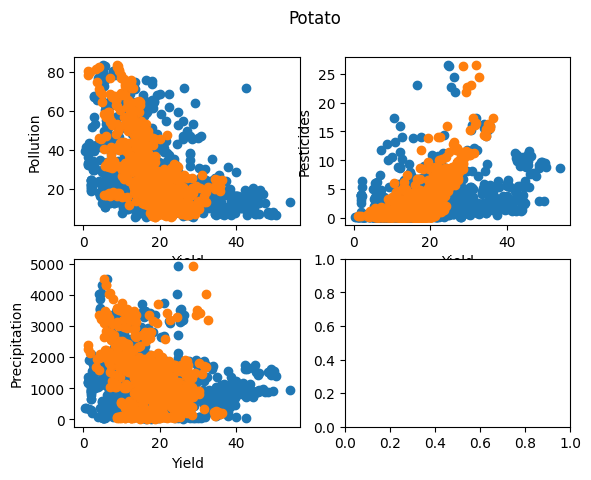

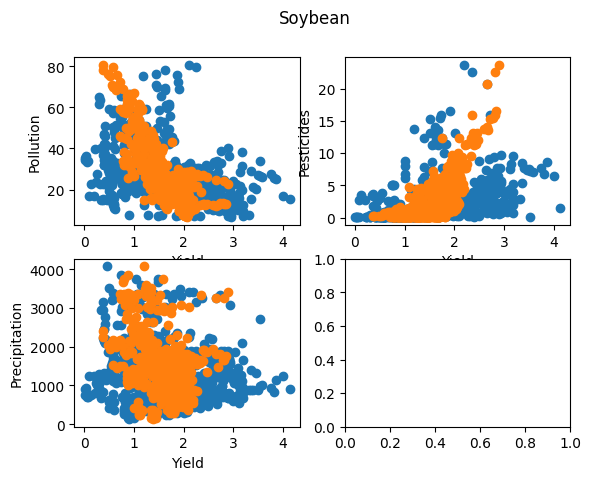

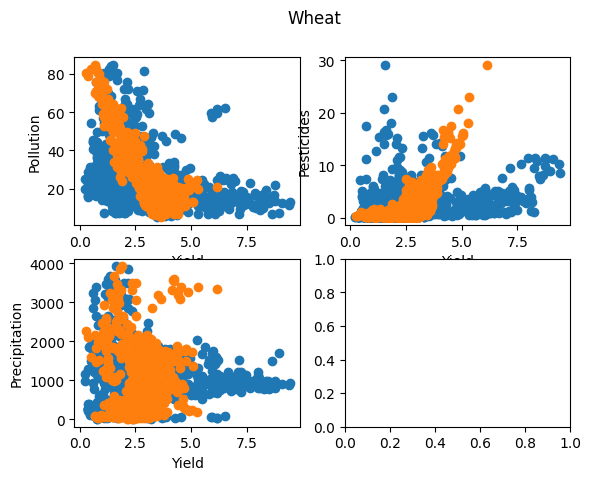

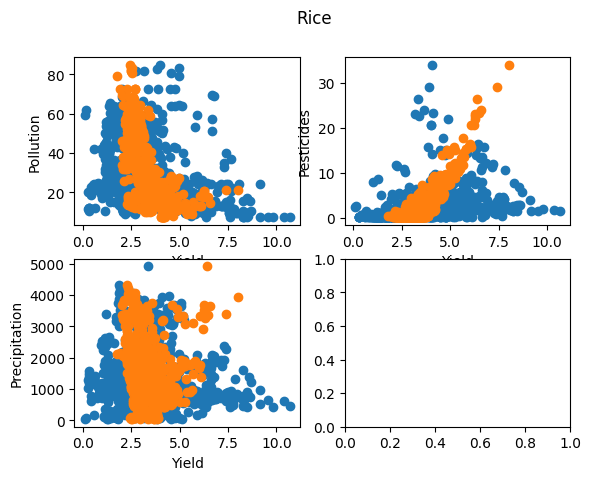

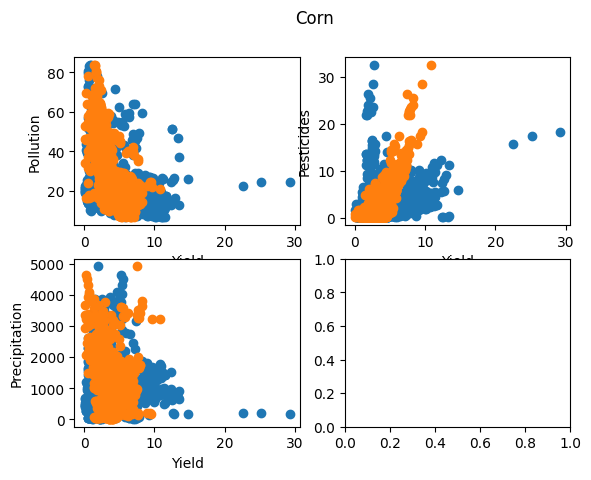

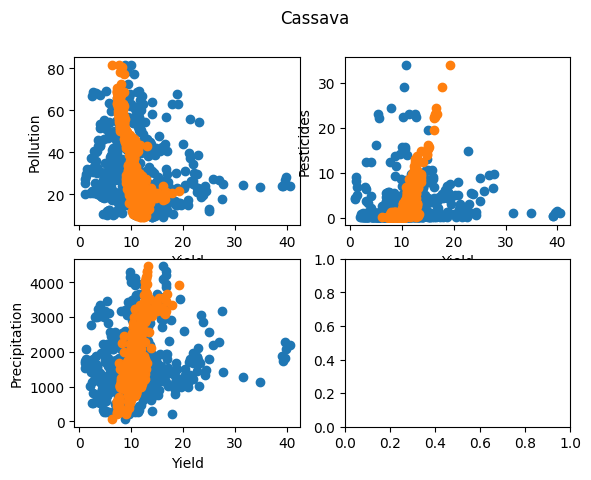

In [30]:
###Without Temperature###

from math import sqrt
def display_results(pred, features_test, target_test, J_storage, features, crop):
    #plt.title(crop)

    #plt.plot(J_storage)

    fig,ax = plt.subplots(2,2)
    
    
    feature = 0
    for row in ax:
        for col in row:
            if feature < len(features):
                plt.suptitle(crop)
                col.set_xlabel("Yield")
                col.set_ylabel(features[feature])
                col.scatter(target_test, features_test[features[feature]])
                col.scatter(pred, features_test[features[feature]])
            feature += 1
    
features = ['Pollution', 'Pesticides', 'Precipitation']
target = ["Yield"]

random_state = 100
test_percent = 0.3

iterations = 1500
alpha = 0.01

#store beta values for site
betas4 = {}

m2e4 = {}

# Read the CSV file
df2: pd.DataFrame = pd.read_csv("CheckData.csv")

#remove temperature table
#remove rows with missing/0 values
df2 = df2.loc[:, ['Crop','Pollution', 'Pesticides', 'Precipitation', 'Yield']]
df2 = df2.replace(0, np.nan)
df2 = df2.dropna()

print(df2)


for crop in Crops:

    beta, pred, features_test, target_test, J_storage, means, stds  = train_model_z(df2, crop, features, target, random_state, test_percent, iterations, alpha)
    betas4[crop] = beta
    m2e4[crop] =  mean_squared_error(target_test,pred)

    print(means)
    print(stds)

    
    display_results(pred, features_test, target_test, J_storage, features, crop)

          Crop  Pollution  Pesticides  Temperature   Yield
0         Corn  22.961579        0.17        12.28  3.6613
2       Potato  22.961579        0.17        12.28  6.6667
3      Soybean  22.961579        0.17        12.28  0.7000
4        Wheat  22.961579        0.17        12.28  3.0197
5         Rice  22.961579        0.17        12.28  2.3333
...        ...        ...         ...          ...     ...
23725  Cassava  19.494180        0.53        21.93  4.8301
23726   Potato  19.494180        0.53        21.93  6.4695
23727  Soybean  19.494180        0.53        21.93  1.8147
23728    Wheat  19.494180        0.53        21.93  4.7796
23729     Rice  19.494180        0.53        21.93  0.6114

[15886 rows x 5 columns]
       Pollution  Pesticides  Temperature
2      22.961579        0.17        12.28
8      22.703110        0.17        11.23
14     22.482896        0.17        11.82
20     22.297132        0.17        11.78
26     22.142012        0.29        12.75
...          .

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packag

[26.23699975  2.69071979 17.98594687]
[15.46563247  3.90027744  7.99807353]
       Pollution  Pesticides  Temperature
3      22.961579        0.17        12.28
9      22.703110        0.17        11.23
15     22.482896        0.17        11.82
21     22.297132        0.17        11.78
27     22.142012        0.29        12.75
...          ...         ...          ...
23703  22.570698        0.53        22.25
23709  17.997754        0.53        21.73
23715  19.112099        0.53        22.09
23721  18.528607        0.53        22.37
23727  19.494180        0.53        21.93

[2060 rows x 3 columns]
[27.45783433  2.43711512 18.74983356]
[14.46358818  3.35998762  7.48038357]
       Pollution  Pesticides  Temperature
4      22.961579        0.17        12.28
10     22.703110        0.17        11.23
16     22.482896        0.17        11.82
22     22.297132        0.17        11.78
28     22.142012        0.29        12.75
...          ...         ...          ...
23704  22.570698        0

C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


[29.14185831  2.35233645 21.83506322]
[15.91077424  3.72668584  5.78199134]
       Pollution  Pesticides  Temperature
0      22.961579        0.17        12.28
6      22.703110        0.17        11.23
12     22.482896        0.17        11.82
18     22.297132        0.17        11.78
24     22.142012        0.29        12.75
...          ...         ...          ...
23700  22.570698        0.53        22.25
23706  17.997754        0.53        21.73
23712  19.112099        0.53        22.09
23718  18.528607        0.53        22.37
23724  19.494180        0.53        21.93

[3360 rows x 3 columns]


C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\megan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


[27.60242705  2.65572704 19.68049745]
[15.08335071  3.76822452  7.24534649]
       Pollution  Pesticides  Temperature
373    23.831767        0.02        21.74
379    23.443967        0.03        21.56
385    23.129464        0.01        21.72
391    22.895329        0.05        21.60
397    22.748636        0.01        21.68
...          ...         ...          ...
23701  22.570698        0.53        22.25
23707  17.997754        0.53        21.73
23713  19.112099        0.53        22.09
23719  18.528607        0.53        22.37
23725  19.494180        0.53        21.93

[1786 rows x 3 columns]
[29.05270247  2.41206235 24.658753  ]
[14.79213363  4.00577583  2.7686855 ]


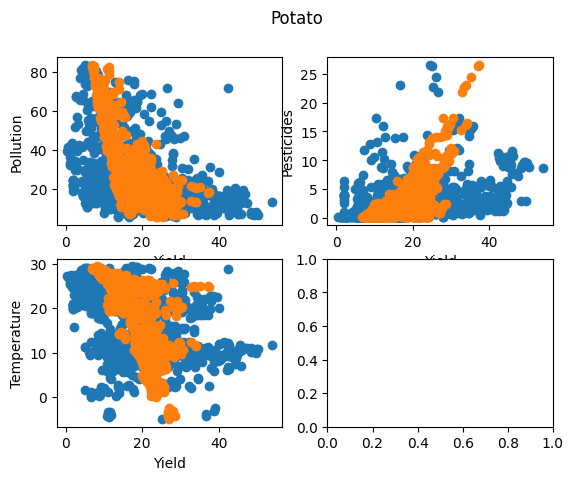

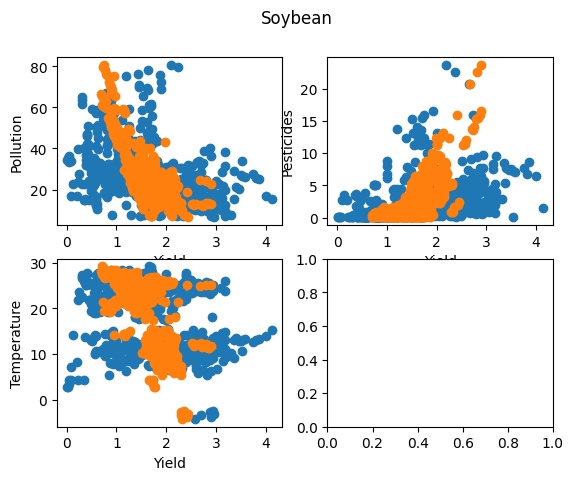

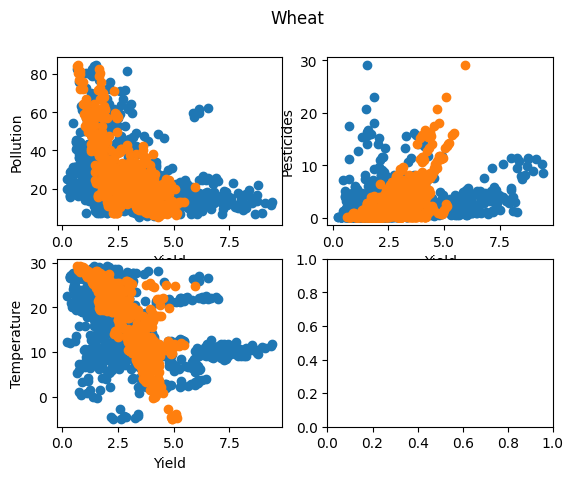

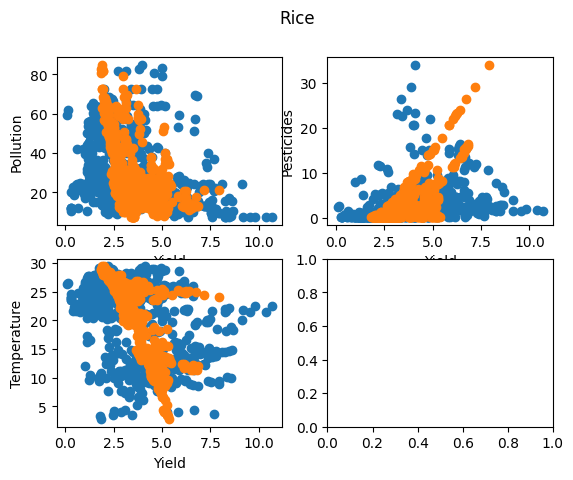

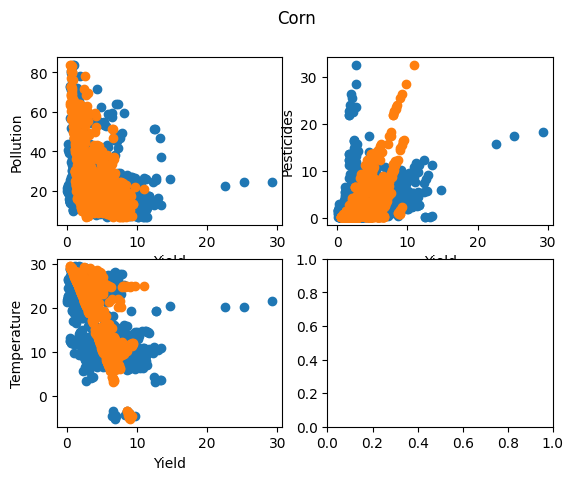

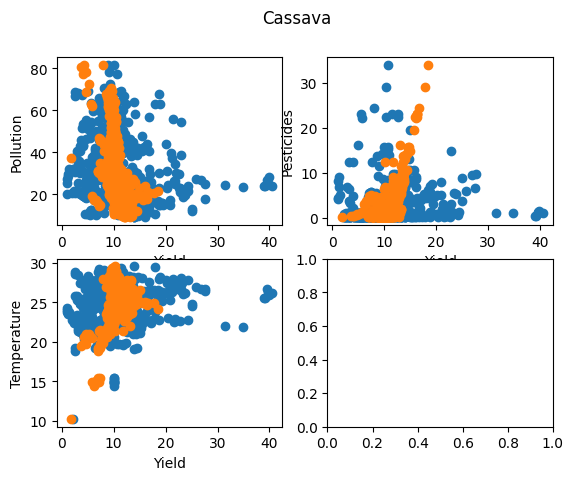

In [31]:
###Without Precipitation###

from math import sqrt
def display_results(pred, features_test, target_test, J_storage, features, crop):
    #plt.title(crop)

    #plt.plot(J_storage)

    fig,ax = plt.subplots(2,2)
    
    
    feature = 0
    for row in ax:
        for col in row:
            if feature < len(features):
                plt.suptitle(crop)
                col.set_xlabel("Yield")
                col.set_ylabel(features[feature])
                col.scatter(target_test, features_test[features[feature]])
                col.scatter(pred, features_test[features[feature]])
            feature += 1
    
features = ['Pollution', 'Pesticides', 'Temperature']
target = ["Yield"]

random_state = 100
test_percent = 0.3

iterations = 1500
alpha = 0.01

#store beta values for site
betas5 = {}

#store m2e
m2e5 = {}

# Read the CSV file
df2: pd.DataFrame = pd.read_csv("CheckData.csv")

#remove precipitation table
#remove rows with missing/0 values
df2 = df2.loc[:, ['Crop','Pollution', 'Pesticides', 'Temperature', 'Yield']]
df2 = df2.replace(0, np.nan)
df2 = df2.dropna()

print(df2)


for crop in Crops:

    beta, pred, features_test, target_test, J_storage, means, stds  = train_model_z(df2, crop, features, target, random_state, test_percent, iterations, alpha)
    betas5[crop] = beta
    m2e5[crop] =  mean_squared_error(target_test,pred)

    print(means)
    print(stds)

    
    display_results(pred, features_test, target_test, J_storage, features, crop)

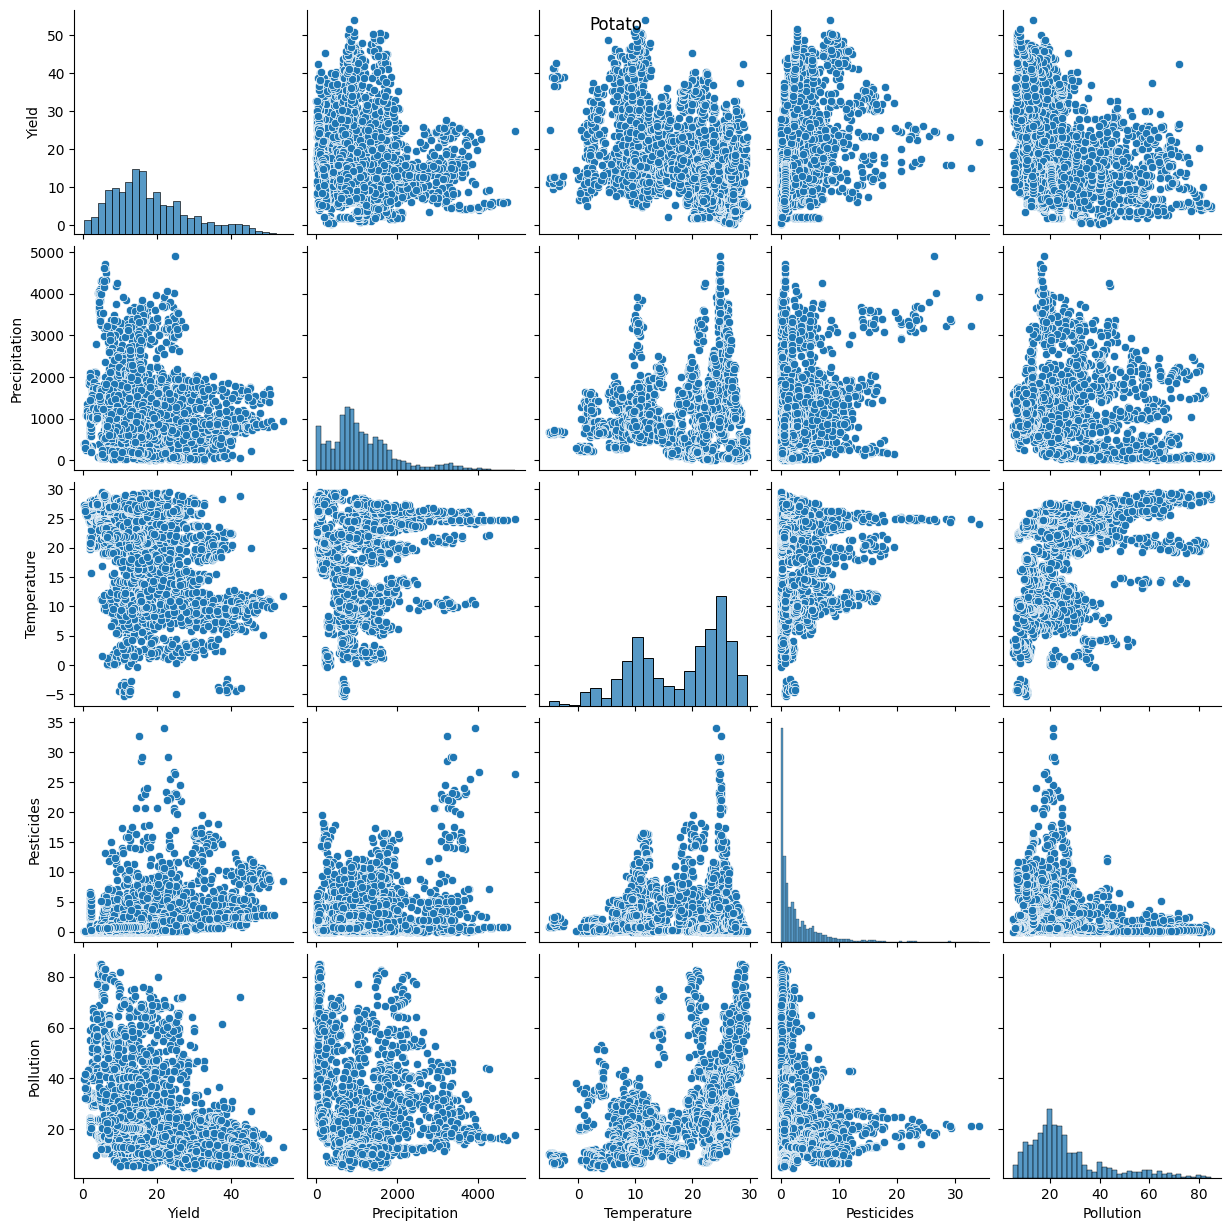

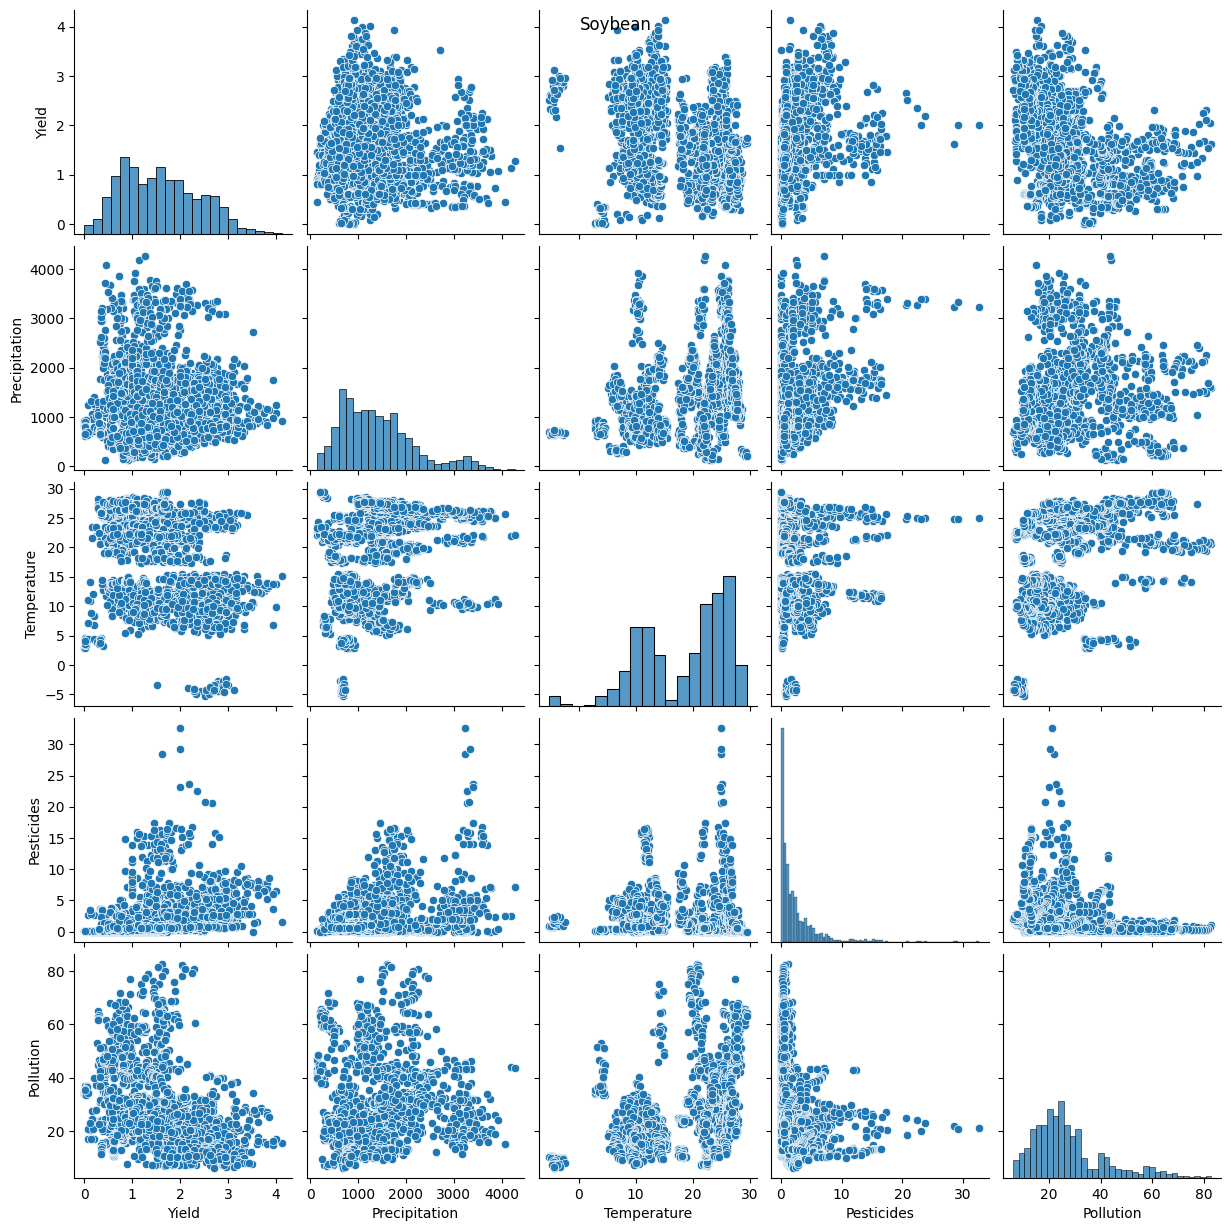

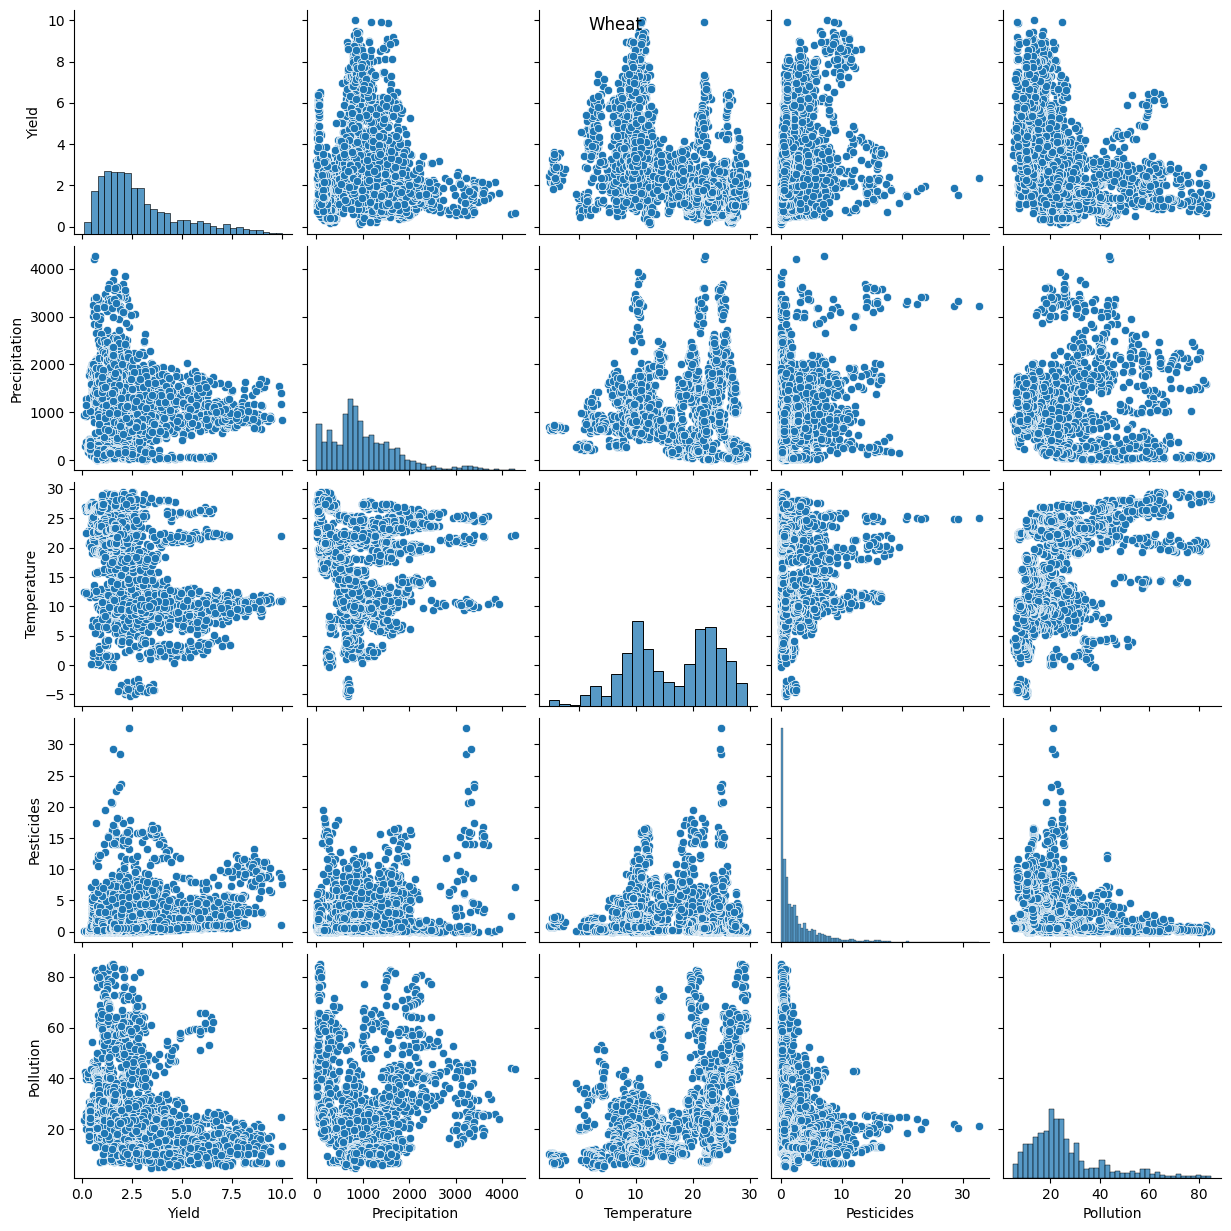

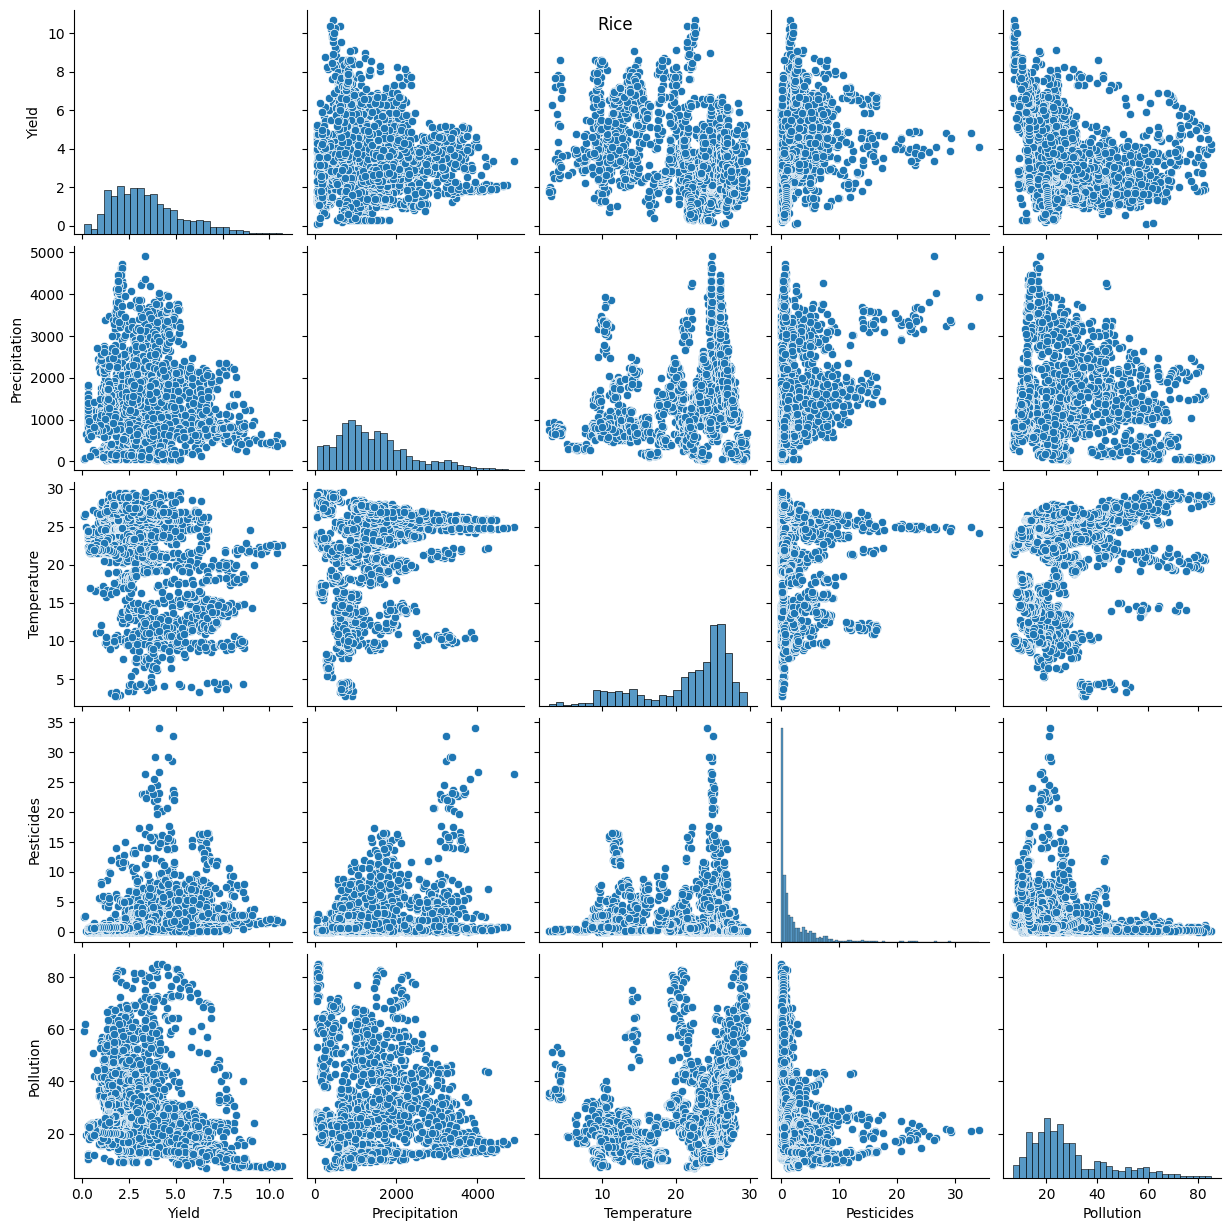

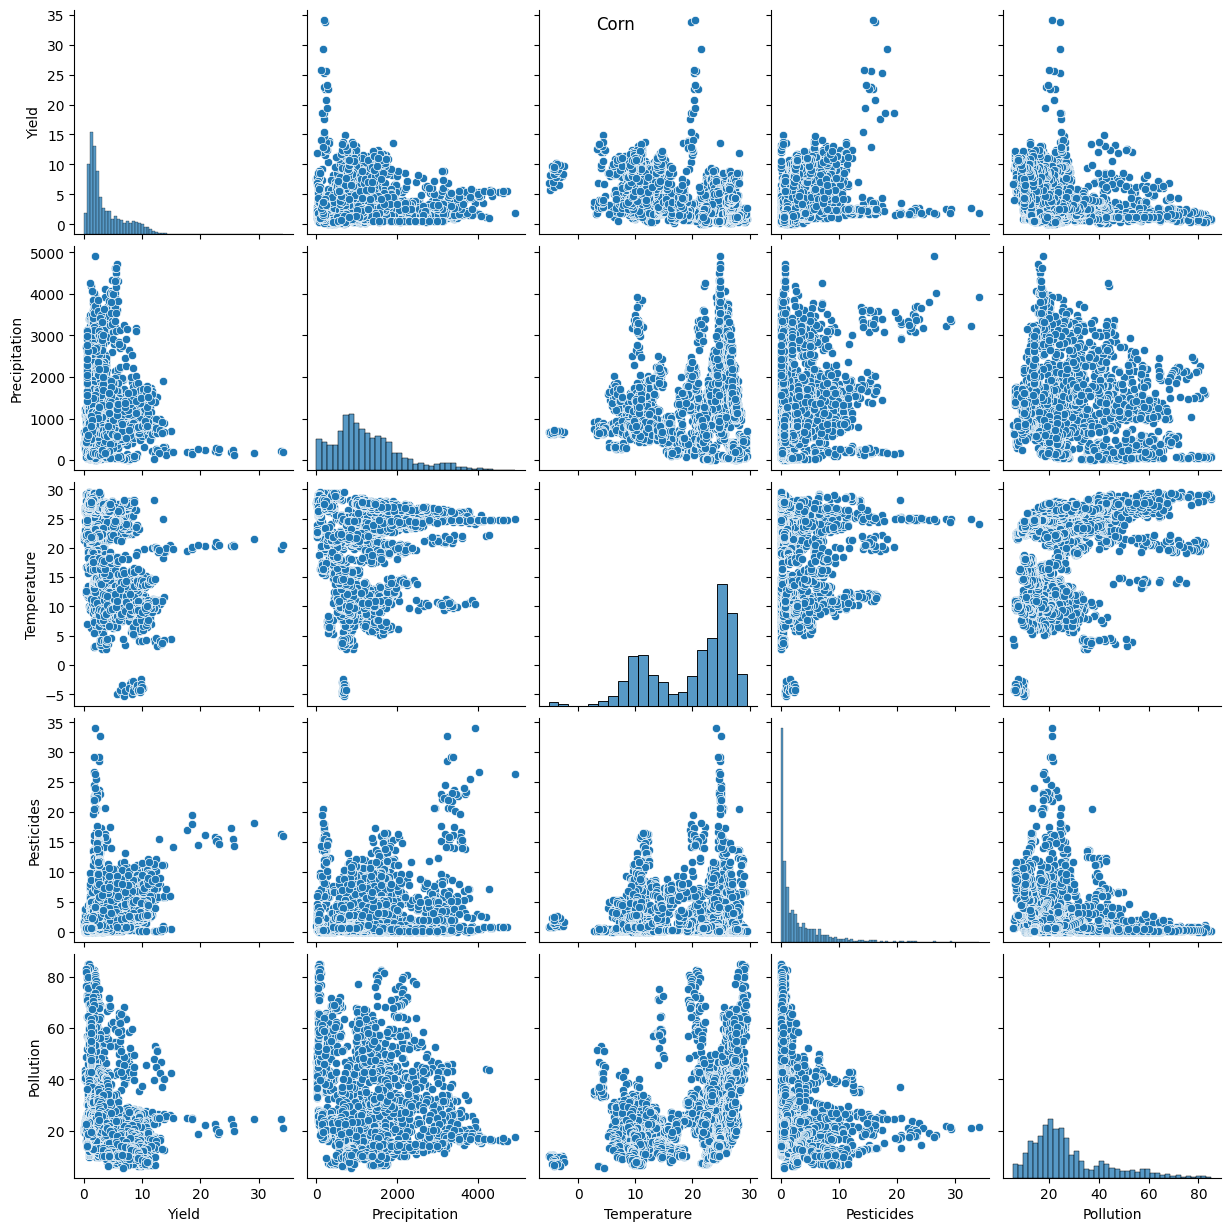

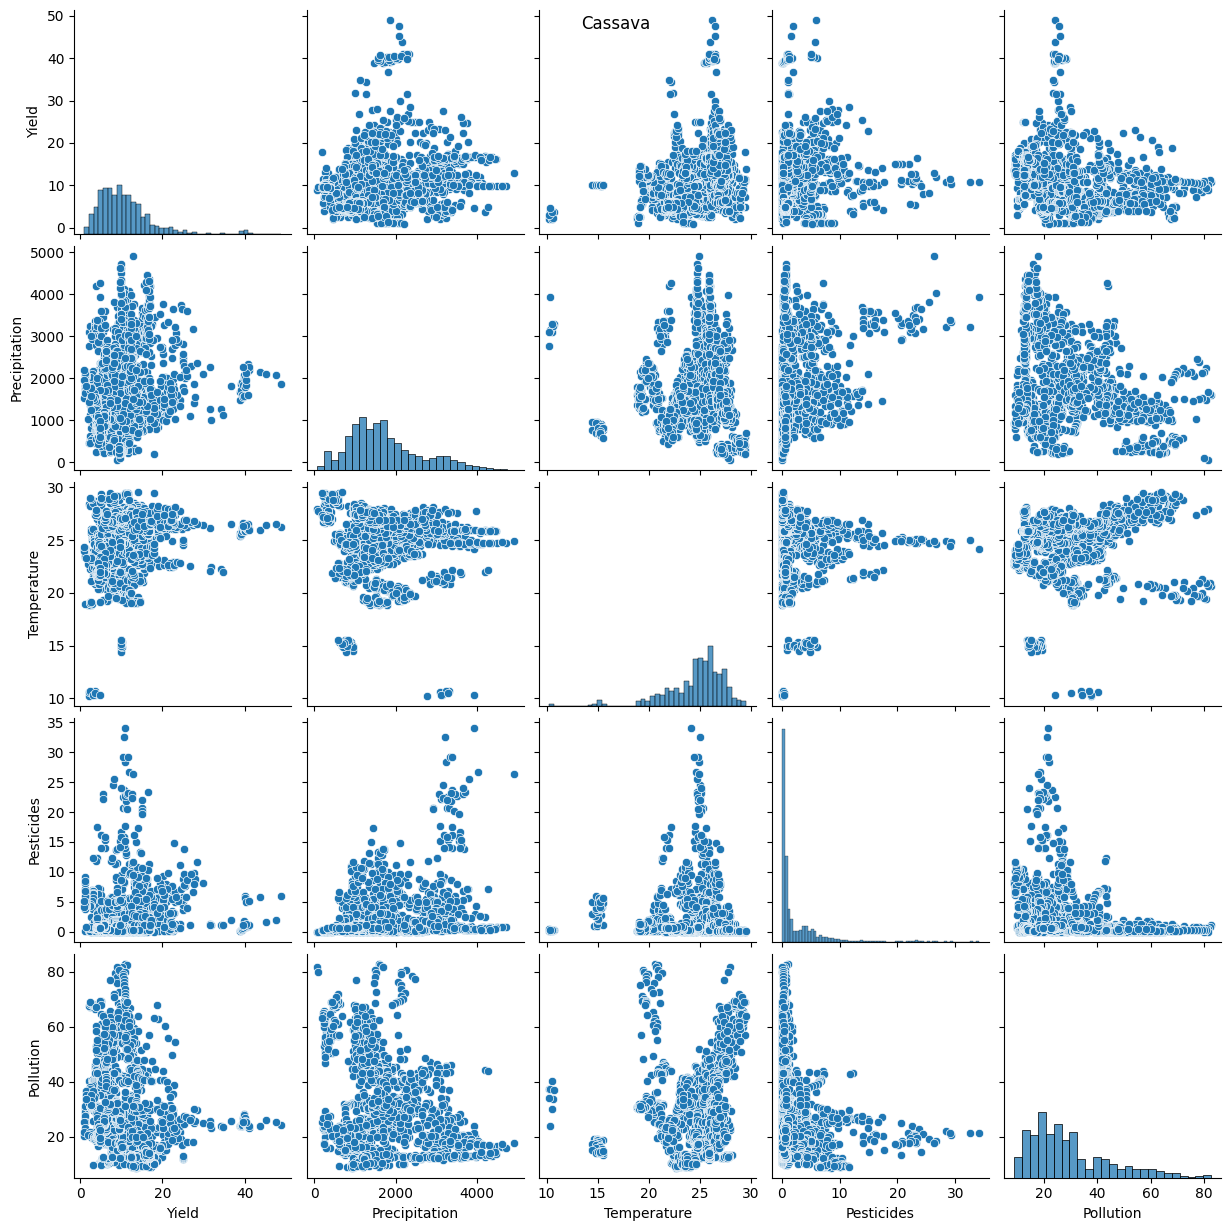

In [32]:
df_data = df.loc[:, ["Crop", "Yield", "Precipitation", "Temperature", "Pesticides", "Pollution"]]
for crop in Crops:
    sns.pairplot(data = df_data[df_data["Crop"] == crop]).fig.suptitle(crop)

In [33]:
print(betas) #z
print(betas2) #minmax
print(betas3) #scaled
print(betas4) #without temperature
print(betas5) #without precipitation
print(betas6) #without pollution
print(betas7) #without pesticides

{'Potato': array([[18.14467658],
       [ 4.05261727],
       [-2.64548464],
       [-1.61457113],
       [-2.60145514]]), 'Soybean': array([[ 1.58583017],
       [ 0.26298947],
       [-0.16083612],
       [-0.17840645],
       [-0.11213534]]), 'Wheat': array([[ 2.87015384],
       [ 0.53180323],
       [-0.76048294],
       [-0.14527727],
       [-0.1687206 ]]), 'Rice': array([[ 3.44034162],
       [ 0.60632698],
       [-0.64445607],
       [-0.13890819],
       [-0.18263675]]), 'Corn': array([[ 3.66508388],
       [ 1.12566249],
       [-1.52735066],
       [-0.11911551],
       [-0.49961753]]), 'Cassava': array([[10.6108354 ],
       [ 0.76750492],
       [ 1.44578981],
       [-0.95765497],
       [ 0.72488331]])}
{'Potato': array([[19.64929665],
       [ 7.01903683],
       [-1.41685354],
       [-4.73376255],
       [-1.10535464]]), 'Soybean': array([[ 1.60751072],
       [ 0.48761705],
       [ 0.03538908],
       [-0.45612037],
       [ 0.03349608]]), 'Wheat': array([[ 3.3411

In [35]:
print("Z")
print(m2e)
print("Min max")
print(m2e2)
print("scaled")
print(m2e3)
print("no temp")
print(m2e4)
print("no preci")
print(m2e5)
print("no poll")
print(m2e6)
print("no pest")
print(m2e7)



Z
{'Potato': Yield    75.845234
dtype: float64, 'Soybean': Yield    0.49008
dtype: float64, 'Wheat': Yield    2.783614
dtype: float64, 'Rice': Yield    2.583292
dtype: float64, 'Corn': Yield    7.393812
dtype: float64, 'Cassava': Yield    34.591926
dtype: float64}
Min max
{'Potato': Yield    105.924669
dtype: float64, 'Soybean': Yield    0.63264
dtype: float64, 'Wheat': Yield    3.276606
dtype: float64, 'Rice': Yield    3.290942
dtype: float64, 'Corn': Yield    10.083035
dtype: float64, 'Cassava': Yield    34.858709
dtype: float64}
scaled
{'Potato': Yield    82.404251
dtype: float64, 'Soybean': Yield    0.521774
dtype: float64, 'Wheat': Yield    2.970479
dtype: float64, 'Rice': Yield    3.075642
dtype: float64, 'Corn': Yield    8.649593
dtype: float64, 'Cassava': Yield    35.431986
dtype: float64}
no temp
{'Potato': Yield    82.918077
dtype: float64, 'Soybean': Yield    0.5125
dtype: float64, 'Wheat': Yield    3.202068
dtype: float64, 'Rice': Yield    2.860769
dtype: float64, 'Corn': Y

In [ ]:
import numpy as np

def normalize_z(array, 
                columns_means=None, 
                columns_stds=None):
    
    if columns_means is None:
        columns_means = np.mean(array, axis=0)
    if columns_stds is None:
        columns_stds = np.std(array, axis=0)
    
    out = np.divide(array - columns_means,columns_stds)
    print(out)
    
    return out, columns_means, columns_stds

def prepare_feature(np_feature):
    

    np_feature = np_feature.reshape(1,-1)

    no_rows = np_feature.shape[0]
    return np.concatenate((np.ones((no_rows,1)), np_feature), axis = 1)

def calc_linreg(X: np.ndarray, beta: np.ndarray):
    
    return np.matmul(X, beta)

def predict_linreg_z(array_feature, beta, 
                   means=None, 
                   stds=None):
    
    normalized, _, _ = normalize_z(array_feature, means, stds)
    X = prepare_feature(normalized)
    return calc_linreg(X, beta)



#inputs - retrieve from site
Temperature = 4
Pollution = 3
Pesticides = 2
Precipitation = 1

X = np.array([Pesticides,Temperature,Pollution,Precipitation])

Crops = ['Soybean', 'Wheat', 'Rice']

#fixed calculated variables from model
betas = {'Potato': np.array([[18.14467658],
       [4.05261727],
       [-2.64548464],
       [-1.61457113],
       [-2.60145514]]), 'Soybean': np.array([[1.58583017],
       [0.26298947],
       [-0.16083612],
       [-0.17840645],
       [-0.11213534]]), 'Wheat': np.array([[2.87015384],
       [0.53180323],
       [-0.76048294],
       [-0.14527727],
       [-0.1687206 ]]), 'Rice': np.array([[3.44034162],
       [0.60632698],
       [-0.64445607],
       [-0.13890819],
       [-0.18263675]]), 'Corn': np.array([[3.66508388],
       [1.12566249],
       [-1.52735066],
       [-0.11911551],
       [-0.49961753]]), 'Cassava': np.array([[10.6108354 ],
       [0.76750492],
       [1.44578981],
       [-0.95765497],
       [0.72488331]])}


def get_best_crop(X, betas, Crops): #returns name of best crop to plant

    crop_ys = {}
    for crop in Crops:
        crop_ys[crop] = predict_linreg_z(X, betas[crop])

    max_yield = 0
    best_crop = []
    for i, v in crop_ys.items():
        if v > max_yield:
            best_crop = i
            max_yield = [v]
        elif v == max_yield:
            best_crop.append(i) 
    
    return best_crop

print(X)
print(Crops)

get_best_crop(X, betas, Crops) 



[2 4 3 1]
['Soybean', 'Wheat', 'Rice']
[-0.4472136   1.34164079  0.4472136  -1.34164079]
[-0.4472136   1.34164079  0.4472136  -1.34164079]
[-0.4472136   1.34164079  0.4472136  -1.34164079]


'Rice'